In [1]:
import datetime
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import gc
from quandl import QuandlError
plt.style.use('alex')

pd.options.display.max_rows = 400
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
from MarketAssist import Market as Market


In [3]:
W = Market.Market(Market_file = 'C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trimmed_filled.csv'
                  ,mavg_df_file = 'C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trim_fill_mavgdf.csv' )

In [ ]:
NormPrice.rolling(window=mavg).mean().values

In [36]:
norm_df[norm_df['Symbol'] == 'AAPL'].NormPrice.rolling(window = 10).std()

278         nan
279         nan
280         nan
281         nan
282         nan
283         nan
284         nan
285         nan
286         nan
287      0.0948
288      0.0873
289      0.0667
290      0.0418
291      0.0282
292      0.0255
293      0.0475
294      0.0611
295      0.0662
296      0.0616
297      0.0604
298      0.1655
299      0.2066
300      0.2335
301      0.2549
302      0.2673
303      0.2797
304      0.2832
305      0.2654
306      0.2270
307      0.1485
308      0.1594
309      0.1507
310      0.1356
311      0.1287
312      0.1261
313      0.1125
314      0.1010
315      0.0737
316      0.0488
317      0.0791
318      0.0854
319      0.0913
320      0.0883
321      0.0896
322      0.0877
323      0.0778
324      0.0657
325      0.0508
326      0.0232
327      0.0323
328      0.0413
329      0.0422
330      0.0572
331      0.0571
332      0.0633
333      0.0584
334      0.0536
335      0.0477
336      0.0703
337      0.0923
338      0.1036
339      0.1027
340     

In [33]:
sym_df.NormPrice.rolling(window=10).std()

AttributeError: 'DataFrame' object has no attribute 'NormPrice'

In [ ]:
NormPrice.rolling(window=mavg).mean().values

In [4]:
W.mavg_df.head()

A-1mavg  A-30mavg  A-5mavg  AA-1mavg  AA-30mavg  AA-5mavg  AAL-1mavg  \
0  46.1764       nan      nan   28.8300        nan       nan    46.0049   
1  46.7823       nan      nan   30.2600        nan       nan    46.4023   
2  46.2260       nan      nan   30.6500        nan       nan    45.5975   
3  47.6663       nan      nan   30.6800        nan       nan    45.9154   
4  47.8153       nan  46.9332   29.4800        nan   29.9800    46.7799   

   AAL-30mavg  AAL-5mavg  AAN-1mavg    ...      ZIXI-5mavg  ZNGA-1mavg  \
0         nan        nan    31.8272    ...             nan      2.6500   
1         nan        nan    32.4957    ...             nan      2.6900   
2         nan        nan    31.2385    ...             nan      2.6500   
3         nan        nan    30.7896    ...             nan      2.7200   
4         nan    46.1400    31.1787    ...          4.9400      2.6600   

   ZNGA-30mavg  ZNGA-5mavg  ZOES-1mavg  ZOES-30mavg  ZOES-5mavg  ZTS-1mavg  \
0          nan         nan     23.4800          nan         nan    53.2879   
1          nan         nan     24.6300          nan         nan    53.8049   
2          nan         nan     25.5500          nan         nan    53.6260   
3          nan         nan     25.7600          nan         nan    53.7950   
4          nan      2.6740     23.6600          nan     24.6160    53.6459   

   ZTS-30mavg  ZTS-5mavg  
0         nan        nan  
1         nan        nan  
2         nan        nan  
3         nan        nan  
4         nan    53.6319  

[5 rows x 4342 columns]

In [122]:
mavg_sets =  [[1,10,30],[1,10,50],[1,30,50]]
hard_thresholds = [0.1,0.3,0.5,0.7]
minmax_thresholds = [0.1,0.15,0.2,0.25]
minmax_windows = [5,10,15]
results = []
for mavg_set in mavg_sets:
    datestart = min(norm_df.Date)


    dateend = (str((datetime.datetime.now().date().year))
              + '-' + str((datetime.datetime.now().date().month))
              + '-' + str((datetime.datetime.now().date().day)))
    
    maxs = W.History[['Symbol','Close']].groupby('Symbol').max()
    mins = W.History[['Symbol','Close']].groupby('Symbol').min()

    norm_df = W.History[['Symbol','Date','Close']]
    norm_df['NormPrice'] = norm_df[['Symbol','Close']].groupby('Symbol').transform(lambda x: (x - min(x)) / ( max(x) - min(x)))

    symbols = norm_df.Symbol.unique()

    mavg_dict = {'Date':norm_df[(norm_df['Date'] >= datestart) 
                                          & (norm_df['Date'] <= dateend)].Date.unique()}

    for symbol in symbols:

        for mavg in mavg_set:

            label = symbol + '-' + str(mavg) + 'mavg'

            mavg_dict[label] = norm_df[(norm_df['Symbol'] == symbol) &
                                         (norm_df['Date'] >= datestart) 
                                          & (norm_df['Date'] <= dateend)].NormPrice.rolling(window=mavg).mean().values

    norm_mavg_df = pd.DataFrame(mavg_dict)
    
    ######### Hard Threshold Runs #####################3
    for hard_threshold in hard_thresholds:
        start_time = time.time()

        threshold = hard_threshold
        headers = ['Date'] + ['mavg' + str(mavg) for mavg in mavg_set] + ['Symbol','Trend','Reversal','Return','Close']
        reversals = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                                headers[1]:'float64',
                                                                headers[2]:'float64',
                                                                headers[3]:'float64',
                                                                headers[4]:str,
                                                                headers[5]:int,
                                                                headers[6]:int,
                                                                headers[7]:'float64',
                                                                headers[8]:'float64'}, parse_date = 'Date')

        all_sym_df = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                                headers[1]:'float64',
                                                                headers[2]:'float64',
                                                                headers[3]:'float64',
                                                                headers[4]:str,
                                                                headers[5]:int,
                                                                headers[6]:int,
                                                                headers[7]:'float64',
                                                                headers[8]:'float64'}, parse_date = 'Date')


        for symbol in W.symbols:
            cols = ['Date']
            for mavg in mavg_set:
                col = symbol + '-' + str(mavg) + 'mavg'
                cols.append(col)

            sym_df = norm_mavg_df.loc[:,cols]
            sym_df = sym_df.fillna(0)
            sym_df = sym_df.assign(Symbol = symbol)
            sym_df = sym_df.assign(Trend = lambda x: x[cols[2]] < x[cols[3]])
            sym_df = sym_df*1
            sym_df = sym_df.assign(Reversal = 0)
            sym_df = sym_df.assign(Return = 0)

            sym_price = pd.DataFrame(W.History.loc[W.History.Symbol == symbol,['Symbol','Date','Close']])
            sym_df = sym_df.merge(sym_price, on = ['Date','Symbol'])

            sym_df.columns = headers
            sym_df = sym_df.assign(Diff = lambda x: x[headers[2]] - sym_df[headers[3]])


            sym_df.loc[(sym_df['Diff'] < threshold) & (sym_df['Diff'].shift(1) > threshold), 'Reversal'] = -1
            sym_df.loc[(sym_df['Diff'] > threshold) & (sym_df['Diff'].shift(1) < threshold), 'Reversal'] = 1



            rev_df = sym_df[sym_df['Reversal'] != 0]
            rev_df = rev_df.assign(Return = lambda x: x.Close - x.Close.shift(1))
            rev_df.loc[rev_df['Reversal'].shift(1) == -1,'Return'] = -rev_df['Return']
            rev_df = rev_df.assign(PriceNormalizedReturn = lambda x: x.Return/x.Close)

            reversals = pd.concat([reversals,rev_df], ignore_index = True)
            all_sym_df = pd.concat([all_sym_df,sym_df],ignore_index = True)

        total_return = reversals.PriceNormalizedReturn.sum()

        results.append([mavg_set,threshold,total_return])
        elapsed_time = time.time() - start_time
        print('{:.3f} seconds | mavg set: {}, hard thresh: {} ------- total return: {:.3f}'.format(elapsed_time,mavg_set, threshold, total_return))
        #gc.collect()
    ############ Flexible Threshold Runs #######################
    for thresh in minmax_thresholds:
        for win in minmax_windows:
            start_time = time.time()
            threshold = thresh
            rolling_days = win
            headers = ['Date'] + ['mavg' + str(mavg) for mavg in mavg_set] + ['Symbol','Trend','Reversal',
                                                                           'Return','Close']
            reversals = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                                    headers[1]:'float64',
                                                                    headers[2]:'float64',
                                                                    headers[3]:'float64',
                                                                    headers[4]:str,
                                                                    headers[5]:int,
                                                                    headers[6]:int,
                                                                    headers[7]:'float64',
                                                                    headers[8]:'float64',}, parse_date = 'Date')

            all_sym_df = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                                    headers[1]:'float64',
                                                                    headers[2]:'float64',
                                                                    headers[3]:'float64',
                                                                    headers[4]:str,
                                                                    headers[5]:int,
                                                                    headers[6]:int,
                                                                    headers[7]:'float64',
                                                                    headers[8]:'float64',}, parse_date = 'Date')


            for symbol in W.symbols:
                cols = ['Date']
                for mavg in mavg_set:
                    col = symbol + '-' + str(mavg) + 'mavg'
                    cols.append(col)

                sym_df = norm_mavg_df.loc[:,cols]
                sym_df = sym_df.fillna(0)
                sym_df = sym_df.assign(Symbol = symbol)
                sym_df = sym_df.assign(Trend = lambda x: x[cols[2]] < x[cols[3]])
                sym_df = sym_df*1
                sym_df = sym_df.assign(Reversal = 0)
                sym_df = sym_df.assign(Return = 0)

                sym_price = pd.DataFrame(W.History.loc[W.History.Symbol == symbol,['Symbol','Date','Close']])
                sym_df = sym_df.merge(sym_price, on = ['Date','Symbol'])



                sym_df.columns = headers
                sym_df = sym_df.assign(Diff = lambda x: x[headers[2]] - sym_df[headers[3]])

                sym_df['RollingDiffMin'] = sym_df.Diff.rolling(rolling_days).min()
                sym_df['RollingDiffMax'] = sym_df.Diff.rolling(rolling_days).max()

                sym_df.loc[(sym_df['RollingDiffMax'] - sym_df['Diff']  > threshold) 
                           & (sym_df['RollingDiffMax'] - sym_df['Diff'].shift(1) < threshold), 'Reversal'] = -1
                sym_df.loc[(sym_df['Diff'] - sym_df['RollingDiffMin'] > threshold) 
                           & (sym_df['Diff'].shift(1) - sym_df['RollingDiffMin'] < threshold), 'Reversal'] = 1



                rev_df = sym_df[sym_df['Reversal'] != 0]
                rev_df = rev_df.assign(Return = lambda x: x.Close - x.Close.shift(1))
                rev_df.loc[rev_df['Reversal'].shift(1) == -1,'Return'] = -rev_df['Return']
                rev_df = rev_df.assign(PriceNormalizedReturn = lambda x: x.Return/x.Close)
                


                reversals = pd.concat([reversals,rev_df], ignore_index = True)
                all_sym_df = pd.concat([all_sym_df,sym_df],ignore_index = True)
                
            total_return = reversals.PriceNormalizedReturn.sum()
            results.append([mavg_set,thresh, win,total_return])
            elapsed_time = time.time() - start_time
            print('{:.3f} seconds | mavg set: {}, rolling_minmax_window: {}, soft thresh: {} ------- total return: {:.3f}'.format(elapsed_time,mavg_set, win, thresh, total_return))
            #gc.collect()

C:\Users\awright\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


113.373 seconds | mavg set: [1, 10, 30], hard thresh: 0.1 ------- total return: -242.336
114.804 seconds | mavg set: [1, 10, 30], hard thresh: 0.3 ------- total return: -22.584
114.165 seconds | mavg set: [1, 10, 30], hard thresh: 0.5 ------- total return: -8.066
114.290 seconds | mavg set: [1, 10, 30], hard thresh: 0.7 ------- total return: -13.765
128.331 seconds | mavg set: [1, 10, 30], rolling_minmax_window: 5, soft thresh: 0.1 ------- total return: 18.420
127.982 seconds | mavg set: [1, 10, 30], rolling_minmax_window: 10, soft thresh: 0.1 ------- total return: -11.908
127.545 seconds | mavg set: [1, 10, 30], rolling_minmax_window: 15, soft thresh: 0.1 ------- total return: -49.957
128.341 seconds | mavg set: [1, 10, 30], rolling_minmax_window: 5, soft thresh: 0.15 ------- total return: 17.853
127.637 seconds | mavg set: [1, 10, 30], rolling_minmax_window: 10, soft thresh: 0.15 ------- total return: 29.335
128.606 seconds | mavg set: [1, 10, 30], rolling_minmax_window: 15, soft thr

In [5]:
maxs = W.History[['Symbol','Close']].groupby('Symbol').max()
mins = W.History[['Symbol','Close']].groupby('Symbol').min()

norm_df = W.History[['Symbol','Date','Close']]
norm_df['NormPrice'] = norm_df[['Symbol','Close']].groupby('Symbol').transform(lambda x: (x - min(x)) / ( max(x) - min(x)))

C:\Users\awright\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
np.std([1,3,5])

1.6329931618554521

In [15]:
mavg_set = [1,50,90]
thresh = 0.1
win = 10

maxs = W.History[['Symbol','Close']].groupby('Symbol').max()
mins = W.History[['Symbol','Close']].groupby('Symbol').min()

norm_df = W.History[['Symbol','Date','Close']]
norm_df['NormPrice'] = norm_df[['Symbol','Close']].groupby('Symbol').transform(lambda x: (x - np.mean(x)) / (np.std(x)))


datestart = min(norm_df.Date)

dateend = (str((datetime.datetime.now().date().year))
          + '-' + str((datetime.datetime.now().date().month))
          + '-' + str((datetime.datetime.now().date().day)))


symbols = norm_df.Symbol.unique()

mavg_dict = {'Date':norm_df[(norm_df['Date'] >= datestart) 
                                      & (norm_df['Date'] <= dateend)].Date.unique()}

for symbol in symbols:

    for mavg in mavg_set:

        label = symbol + '-' + str(mavg) + 'mavg'

        mavg_dict[label] = norm_df[(norm_df['Symbol'] == symbol) &
                                     (norm_df['Date'] >= datestart) 
                                      & (norm_df['Date'] <= dateend)].NormPrice.rolling(window=mavg).mean().values

norm_mavg_df = pd.DataFrame(mavg_dict)

start_time = time.time()
threshold = thresh
rolling_days = win
headers = ['Date'] + ['mavg' + str(mavg) for mavg in mavg_set] + ['Symbol','Trend','Reversal',
                                                               'Return','Close']
reversals = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64',
                                                        headers[8]:'float64',}, parse_date = 'Date')

all_sym_df = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64',
                                                        headers[8]:'float64',}, parse_date = 'Date')


for symbol in W.symbols:
    cols = ['Date']
    for mavg in mavg_set:
        col = symbol + '-' + str(mavg) + 'mavg'
        cols.append(col)

    sym_df = norm_mavg_df.loc[:,cols]
    sym_df = sym_df.fillna(0)
    sym_df = sym_df.assign(Symbol = symbol)
    sym_df = sym_df.assign(Trend = lambda x: x[cols[2]] < x[cols[3]])
    sym_df = sym_df*1
    sym_df = sym_df.assign(Reversal = 0)
    sym_df = sym_df.assign(Return = 0)

    sym_price = pd.DataFrame(W.History.loc[W.History.Symbol == symbol,['Symbol','Date','Close']])
    sym_df = sym_df.merge(sym_price, on = ['Date','Symbol'])



    sym_df.columns = headers
    sym_df = sym_df.assign(Diff = lambda x: x[headers[2]] - sym_df[headers[3]])

    sym_df['RollingDiffMin'] = sym_df.Diff.rolling(rolling_days).min()
    sym_df['RollingDiffMax'] = sym_df.Diff.rolling(rolling_days).max()

    sym_df.loc[(sym_df['Diff']  < threshold - 0.1) 
               & (sym_df['Diff'].shift(1) > threshold - 0.1)
               & (sym_df['Date'] >= min(sym_df.loc[sym_df[headers[3]] > 0 ].Date).to_pydatetime()), 'Reversal'] = -1
    sym_df.loc[(sym_df['Diff'] > threshold) 
               & (sym_df['Diff'].shift(1) < threshold)
               & (sym_df['Date'] >= min(sym_df.loc[sym_df[headers[3]] > 0 ].Date).to_pydatetime()), 'Reversal'] = 1
    
    if sym_df.loc[sym_df.Reversal != 0].Date.count() > 0:
        sym_df.loc[sym_df.Date == max(sym_df.Date),'Reversal'] = sym_df.loc[sym_df.Date == max(sym_df.loc[sym_df.Reversal != 0].Date).to_pydatetime()].Reversal.values[0]

    
    rev_df = sym_df[sym_df['Reversal'] != 0]
    rev_df = rev_df.assign(Return = lambda x: x.Close - x.Close.shift(1))
    rev_df.loc[rev_df['Reversal'].shift(1) == -1,'Return'] = -rev_df['Return']
    rev_df = rev_df.assign(PriceNormalizedReturn = lambda x: x.Return/x.Close)



    reversals = pd.concat([reversals,rev_df], ignore_index = True)
    all_sym_df = pd.concat([all_sym_df,sym_df],ignore_index = True)

total_return = reversals.PriceNormalizedReturn.sum()
results.append([mavg_set,thresh, win,total_return])
elapsed_time = time.time() - start_time
print('{:.3f} seconds | mavg set: {}, rolling_minmax_window: {}, soft thresh: {} ------- total return: {:.3f}'.format(elapsed_time,mavg_set, win, thresh, total_return))
#gc.collect()

C:\Users\awright\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


NameError: name 'results' is not defined

In [17]:
reversals.Return.sum()

-174.30964097846925

In [94]:
sym_df.loc[sym_df.Reversal != 0].Date.count() == 0  

True

In [76]:
sym_df.loc[sym_df.Date == max(sym_df.Date),'Reversal'] = -sym_df.loc[sym_df.Date == max(sym_df.loc[sym_df.Reversal != 0].Date).to_pydatetime()].Reversal.values[0]

C:\Users\awright\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [77]:
sym_df.loc[sym_df.Date == max(sym_df.Date),'Reversal']

301040    1
Name: Reversal, dtype: int64

In [73]:
-sym_df.loc[sym_df.Date == max(sym_df.loc[sym_df.Reversal != 0].Date).to_pydatetime()].Reversal.values[0]

1

In [53]:
pd.options.display.max_rows = 500

In [25]:
sym_df

Close       Date    Diff  Return  Reversal  RollingDiffMax  \
393948 17.9317 2017-01-03  0.0000  0.0000         0             nan   
393949 18.6002 2017-01-04  0.0000  0.0000         0             nan   
393950 18.3151 2017-01-05  0.0000  0.0000         0             nan   
393951 18.1480 2017-01-06  0.0000  0.0000         0             nan   
393952 18.4429 2017-01-09  0.0000  0.0000         0             nan   
393953 18.6592 2017-01-10  0.0000  0.0000         0             nan   
393954 18.6690 2017-01-11  0.0000  0.0000         0             nan   
393955 18.8165 2017-01-12  0.0000  0.0000         0             nan   
393956 19.1507 2017-01-13  0.0000  0.0000         0             nan   
393957 18.9639 2017-01-17  0.0000  0.0000         0          0.0000   
393958 19.2589 2017-01-18  0.0000  0.0000         0          0.0000   
393959 19.0819 2017-01-19  0.0000  0.0000         0          0.0000   
393960 19.1016 2017-01-20  0.0000  0.0000         0          0.0000   
393961 18.9639 2017-01-23  0.0000  0.0000         0          0.0000   
393962 19.1999 2017-01-24  0.0000  0.0000         0          0.0000   
393963 19.3572 2017-01-25  0.0000  0.0000         0          0.0000   
393964 19.2982 2017-01-26  0.0000  0.0000         0          0.0000   
393965 19.1704 2017-01-27  0.0000  0.0000         0          0.0000   
393966 19.2392 2017-01-30  0.0000  0.0000         0          0.0000   
393967 19.2490 2017-01-31  0.0000  0.0000         0          0.0000   
393968 19.2785 2017-02-01  0.0000  0.0000         0          0.0000   
393969 19.1311 2017-02-02  0.0000  0.0000         0          0.0000   
393970 19.3670 2017-02-03  0.0000  0.0000         0          0.0000   
393971 19.3277 2017-02-06  0.0000  0.0000         0          0.0000   
393972 19.2392 2017-02-07  0.0000  0.0000         0          0.0000   
393973 18.9541 2017-02-08  0.0000  0.0000         0          0.0000   
393974 20.6057 2017-02-09  0.0000  0.0000         0          0.0000   
393975 21.5986 2017-02-10  0.0000  0.0000         0          0.0000   
393976 22.2770 2017-02-13  0.0000  0.0000         0          0.0000   
393977 22.1197 2017-02-14  0.0000  0.0000         0          0.0000   
393978 22.2377 2017-02-15  0.0000  0.0000         0          0.0000   
393979 21.7363 2017-02-16  0.0000  0.0000         0          0.0000   
393980 21.7658 2017-02-17  0.0000  0.0000         0          0.0000   
393981 21.8837 2017-02-21  0.0000  0.0000         0          0.0000   
393982 21.2742 2017-02-22  0.0000  0.0000         0          0.0000   
393983 20.9990 2017-02-23  0.0000  0.0000         0          0.0000   
393984 21.0874 2017-02-24  0.0000  0.0000         0          0.0000   
393985 21.0973 2017-02-27  0.0000  0.0000         0          0.0000   
393986 20.6254 2017-02-28  0.0000  0.0000         0          0.0000   
393987 20.5172 2017-03-01  0.0000  0.0000         0          0.0000   
393988 20.1732 2017-03-02  0.0000  0.0000         0          0.0000   
393989 20.6155 2017-03-03  0.0000  0.0000         0          0.0000   
393990 20.5566 2017-03-06  0.0000  0.0000         0          0.0000   
393991 20.2125 2017-03-07  0.0000  0.0000         0          0.0000   
393992 20.1633 2017-03-08  0.0000  0.0000         0          0.0000   
393993 19.9569 2017-03-09  0.0000  0.0000         0          0.0000   
393994 19.9175 2017-03-10  0.0000  0.0000         0          0.0000   
393995 20.0454 2017-03-13  0.0000  0.0000         0          0.0000   
393996 20.0355 2017-03-14  0.0000  0.0000         0          0.0000   
393997 20.3025 2017-03-15 -0.7611  0.0000         0          0.0000   
393998 20.5695 2017-03-16 -0.7495  0.0000         0          0.0000   
393999 20.8563 2017-03-17 -0.7396  0.0000         0          0.0000   
394000 21.0046 2017-03-20 -0.7278  0.0000         0          0.0000   
394001 20.8662 2017-03-21 -0.7158  0.0000         0          0.0000   
394002 20.8464 2017-03-22 -0.7053  0.0000         0          0.0000   
394003 21.4991 2017-03-23 -0.6928

In [27]:
all_sym_df

Close       Date    Diff  Return  Reversal  RollingDiffMax  \
0      46.1764 2017-01-03  0.0000  0.0000         0             nan   
1      46.7823 2017-01-04  0.0000  0.0000         0             nan   
2      46.2260 2017-01-05  0.0000  0.0000         0             nan   
3      47.6663 2017-01-06  0.0000  0.0000         0             nan   
4      47.8153 2017-01-09  0.0000  0.0000         0             nan   
5      47.7755 2017-01-10  0.0000  0.0000         0             nan   
6      48.9178 2017-01-11  0.0000  0.0000         0             nan   
7      48.1927 2017-01-12  0.0000  0.0000         0             nan   
8      48.3615 2017-01-13  0.0000  0.0000         0             nan   
9      47.9940 2017-01-17  0.0000  0.0000         0          0.0000   
10     47.9245 2017-01-18  0.0000  0.0000         0          0.0000   
11     47.3186 2017-01-19  0.0000  0.0000         0          0.0000   
12     47.2988 2017-01-20  0.0000  0.0000         0          0.0000   
13     47.0703 2017-01-23  0.0000  0.0000         0          0.0000   
14     47.0306 2017-01-24  0.0000  0.0000         0          0.0000   
15     48.0834 2017-01-25  0.0000  0.0000         0          0.0000   
16     47.8451 2017-01-26  0.0000  0.0000         0          0.0000   
17     48.3218 2017-01-27  0.0000  0.0000         0          0.0000   
18     47.3484 2017-01-30  0.0000  0.0000         0          0.0000   
19     48.6397 2017-01-31  0.0000  0.0000         0          0.0000   
20     48.9277 2017-02-01  0.0000  0.0000         0          0.0000   
21     48.5701 2017-02-02  0.0000  0.0000         0          0.0000   
22     49.0469 2017-02-03  0.0000  0.0000         0          0.0000   
23     48.9376 2017-02-06  0.0000  0.0000         0          0.0000   
24     49.3051 2017-02-07  0.0000  0.0000         0          0.0000   
25     49.5932 2017-02-08  0.0000  0.0000         0          0.0000   
26     50.1295 2017-02-09  0.0000  0.0000         0          0.0000   
27     50.0203 2017-02-10  0.0000  0.0000         0          0.0000   
28     50.1792 2017-02-13  0.0000  0.0000         0          0.0000   
29     50.0501 2017-02-14  0.0000  0.0000         0          0.0000   
30     51.2718 2017-02-15  0.0000  0.0000         0          0.0000   
31     50.4970 2017-02-16  0.0000  0.0000         0          0.0000   
32     51.2817 2017-02-17  0.0000  0.0000         0          0.0000   
33     51.0036 2017-02-21  0.0000  0.0000         0          0.0000   
34     50.9937 2017-02-22  0.0000  0.0000         0          0.0000   
35     51.1228 2017-02-23  0.0000  0.0000         0          0.0000   
36     51.3910 2017-02-24  0.0000  0.0000         0          0.0000   
37     51.3115 2017-02-27  0.0000  0.0000         0          0.0000   
38     50.9539 2017-02-28  0.0000  0.0000         0          0.0000   
39     51.6889 2017-03-01  0.0000  0.0000         0          0.0000   
40     51.0334 2017-03-02  0.0000  0.0000         0          0.0000   
41     51.6293 2017-03-03  0.0000  0.0000         0          0.0000   
42     50.9043 2017-03-06  0.0000  0.0000         0          0.0000   
43     50.8645 2017-03-07  0.0000  0.0000         0          0.0000   
44     51.0632 2017-03-08  0.0000  0.0000         0          0.0000   
45     51.0831 2017-03-09  0.0000  0.0000         0          0.0000   
46     51.7982 2017-03-10  0.0000  0.0000         0          0.0000   
47     52.0962 2017-03-13  0.0000  0.0000         0          0.0000   
48     51.8578 2017-03-14  0.0000  0.0000         0          0.0000   
49     53.7350 2017-03-15 -1.4589  0.0000         0          0.0000   
50     52.6921 2017-03-16 -1.4413  0.0000         0          0.0000   
51     52.9504 2017-03-17 -1.4246  0.0000         0          0.0000   
52     52.7915 2017-03-20 -1.4069  0.0000         0          0.0000   
53     52.3048 2017-03-21 -1.3943  0.0000         0          0.0000   
54     52.7716 2017-03-22 -1.3809  0.0000         0          0.0000   
55     52.8213 2017-03-23 -1.3673

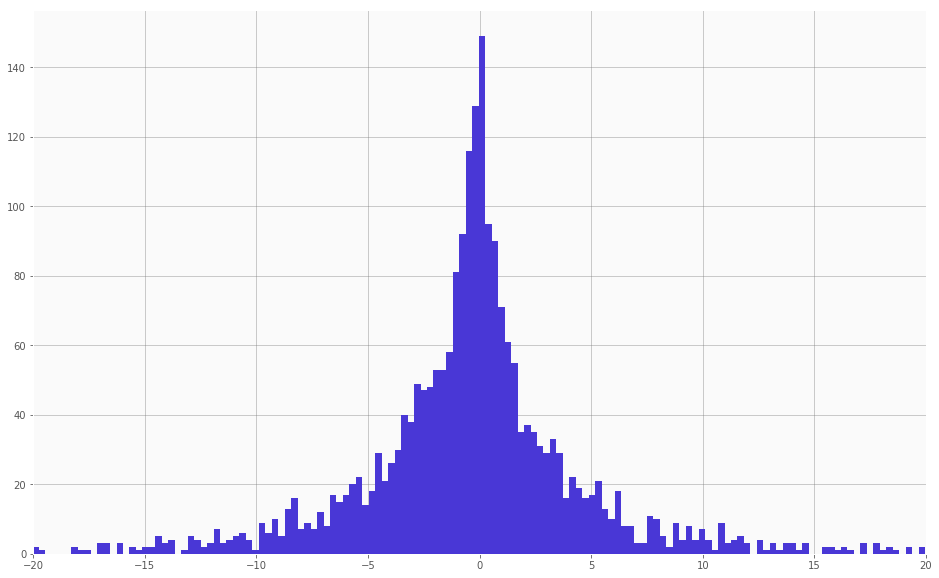

In [18]:
reversals.Return.hist(bins = 1000, figsize = (16,10), color = W.colors[1])
plt.xlim(-20,20)
plt.show()

In [55]:
reversals[(reversals.Reversal == 1) & (reversals.Reversal.shift(1) == -1)].head(500)

Close       Date   Diff  PriceNormalizedReturn    Return  Reversal  \
3       39.2300 2017-08-16 0.1026                -0.2077   -8.1500         1   
5       53.1000 2018-01-19 0.1068                -0.2203  -11.7000         1   
7       49.3833 2017-06-12 0.1084                -0.0462   -2.2833         1   
9       52.9900 2018-01-02 0.1025                -0.1636   -8.6700         1   
12      68.6300 2017-05-24 0.1037                    nan       nan         1   
15      35.2500 2017-11-27 0.1006                -0.0440   -1.5500         1   
17     117.0200 2018-01-19 0.1003                 0.2476   28.9735         1   
19     161.5000 2017-09-11 0.1029                -0.0729  -11.7675         1   
23      88.3416 2017-09-28 0.1013                    nan       nan         1   
26      95.0954 2017-06-26 0.1029                -0.0856   -8.1429         1   
28      92.4600 2017-12-22 0.1049                -0.1425  -13.1759         1   
35      34.7200 2017-08-30 0.1091                -0.1630   -5.6600         1   
42      12.9000 2017-10-18 0.1075                -0.1202   -1.5500         1   
45     102.1500 2017-10-20 0.1041                -0.0898   -9.1700         1   
47      49.3600 2017-07-14 0.1037                    nan       nan         1   
50       4.2300 2017-06-21 0.1003                -0.0733   -0.3100         1   
52      24.1400 2017-07-26 0.1005                    nan       nan         1   
54      24.6000 2017-10-27 0.1032                -0.1077   -2.6500         1   
57      37.0600 2017-10-02 0.1134                -0.1015   -3.7600         1   
60      21.7000 2017-07-27 0.1112                -0.2765   -6.0000         1   
64      13.6400 2017-10-13 0.1048                -0.0709   -0.9665         1   
67       2.9500 2017-08-21 0.1032                -0.1271   -0.3750         1   
71      26.5100 2017-11-21 0.1048                -0.0230   -0.6100         1   
80      87.8900 2017-10-05 0.1043                -0.0773   -6.7900         1   
82      42.1637 2017-09-29 0.1040                -0.0202   -0.8505         1   
86      23.1100 2017-10-06 0.1028                -0.3721   -8.6000         1   
89     111.1881 2017-08-03 0.1034                -0.1418  -15.7691         1   
94     250.4200 2017-12-27 0.1048                -0.1127  -28.2100         1   
99      23.5496 2017-08-01 0.1017                -0.1470   -3.4620         1   
102     59.8173 2017-08-24 0.1062                    nan       nan         1   
105     86.1000 2017-10-12 0.1017                -0.1160   -9.9900         1   
108     27.7674 2017-07-21 0.1056                -0.1371   -3.8081         1   
112     14.1721 2017-10-02 0.1079                -0.0027   -0.0377         1   
118     55.0500 2017-06-22 0.1041                -0.2716  -14.9500         1   
122     11.6718 2017-06-13 0.1040                -0.0302   -0.3522         1   
125     10.6000 2018-02-05 0.1029                 0.0028    0.0300         1   
133     64.8281 2017-06-05 0.1063                    nan       nan         1   
137      4.8800 2017-07-19 0.1033                -0.2213   -1.0800         1   
139      4.6700 2017-10-17 0.1046                -0.2141   -1.0000         1   
142    249.5937 2017-08-03 0.1007                -0.1186  -29.6091         1   
146     41.6058 2017-06-30 0.1059                -0.0676   -2.8123         1   
151      6.9100 2017-10-11 0.1065                -0.1285   -0.8877         1   
154     62.7145 2017-06-22 0.1057                -0.0315   -1.9756         1   
156     62.0000 2017-11-13 0.1015                -0.0459   -2.8465         1   
164     45.4200 2017-08-21 0.1029                -0.0411   -1.8652         1   
166     98.0211 2017-05-30 0.1012                    nan       nan         1   
168     99.5100 2018-01-03 0.1004                -0.0493   -4.9100         1   
170     62.0200 2017-10-13 0.1020                    nan       nan         1   
172     54.2600 2017-11-10 0.1017                -0.0813   -4.4100         1   
174     14

In [16]:
min(sym_df.loc[sym_df[headers[3]] > 0 ].Date).to_pydatetime()

datetime.datetime(2017, 2, 14, 0, 0)

In [20]:
import random

In [ ]:
n_syms = all_sym_df.Symbol

In [84]:
random.sample(all_sym_df.Symbol.unique().tolist(),10)

['TUES', 'GIS', 'MA', 'CAR', 'SPLK', 'NCLH', 'WDR', 'KHC', 'MXIM', 'PEIX']

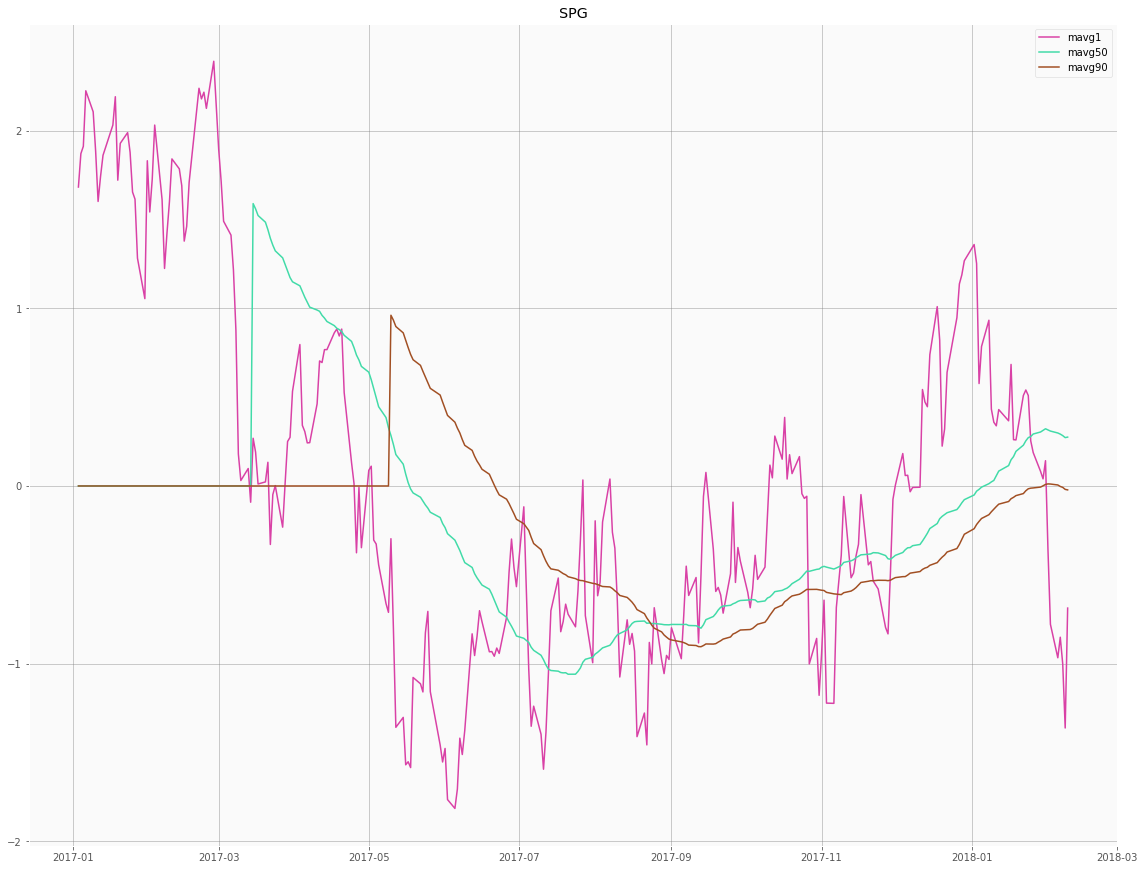

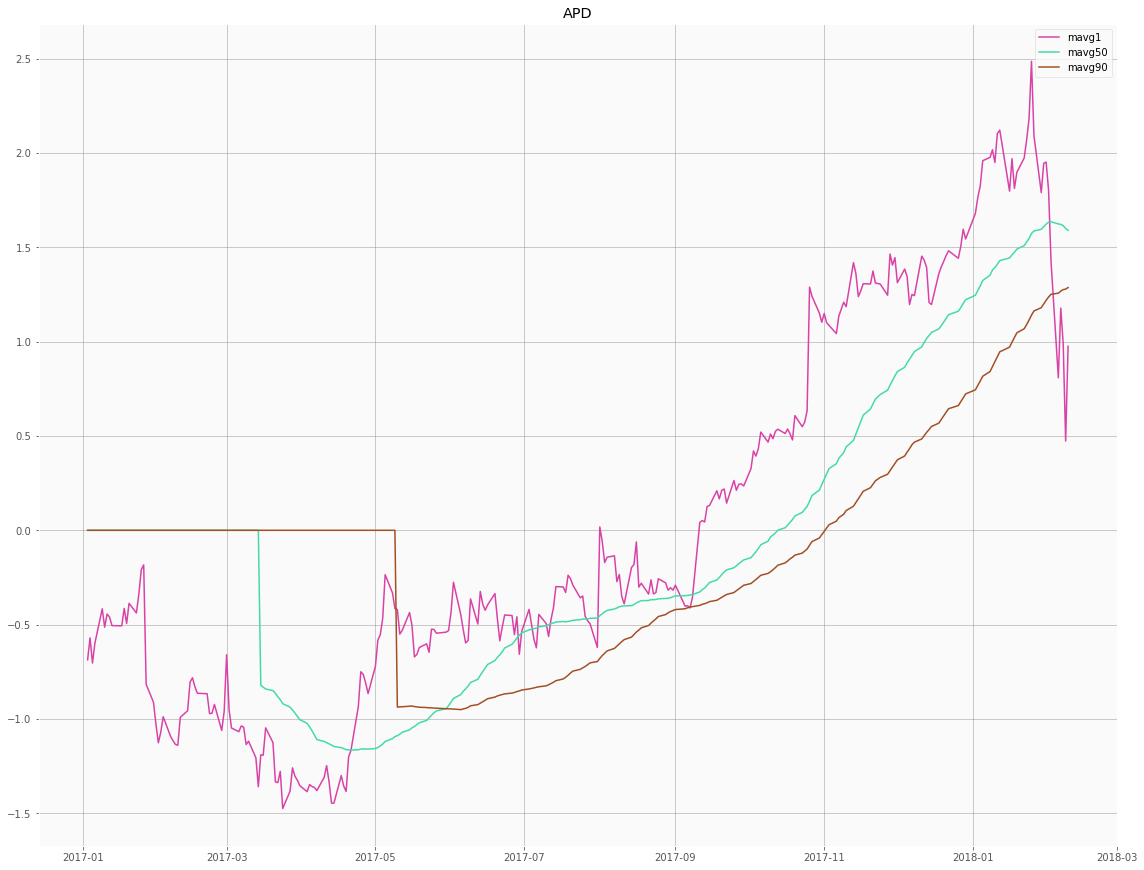

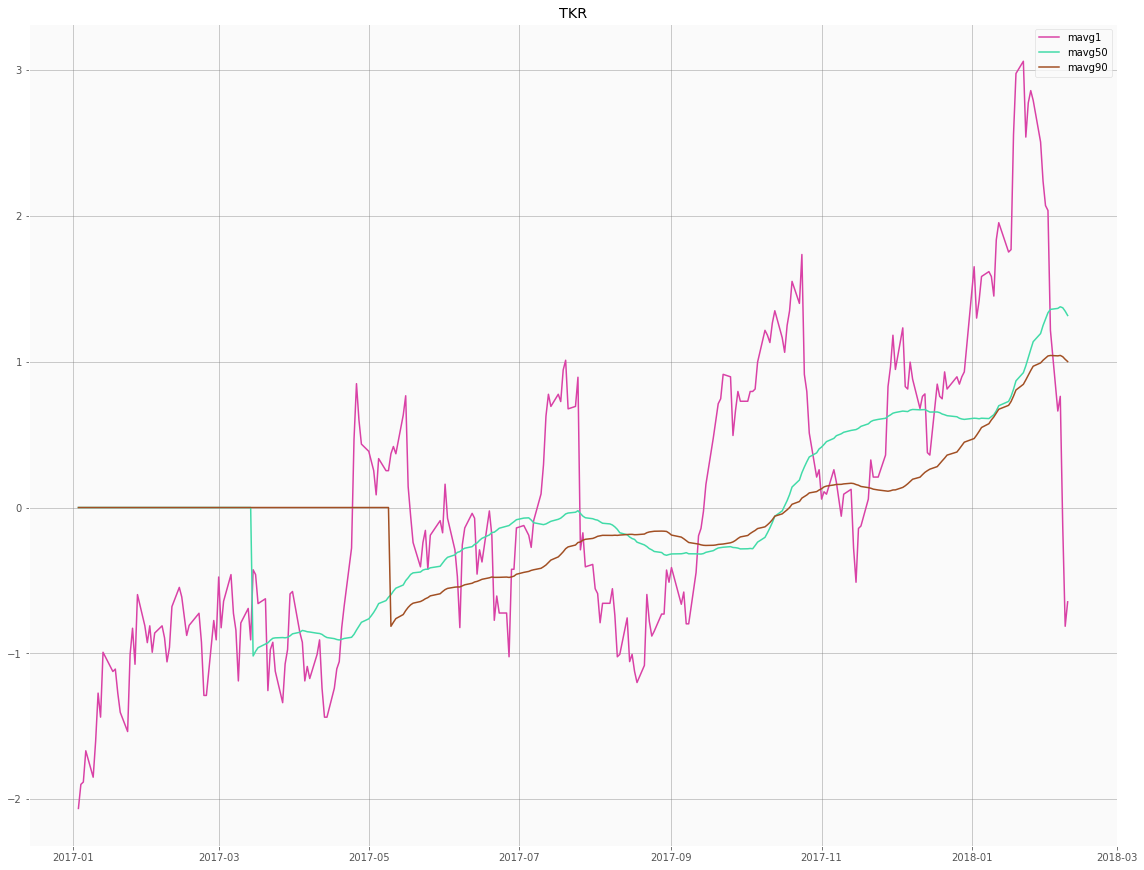

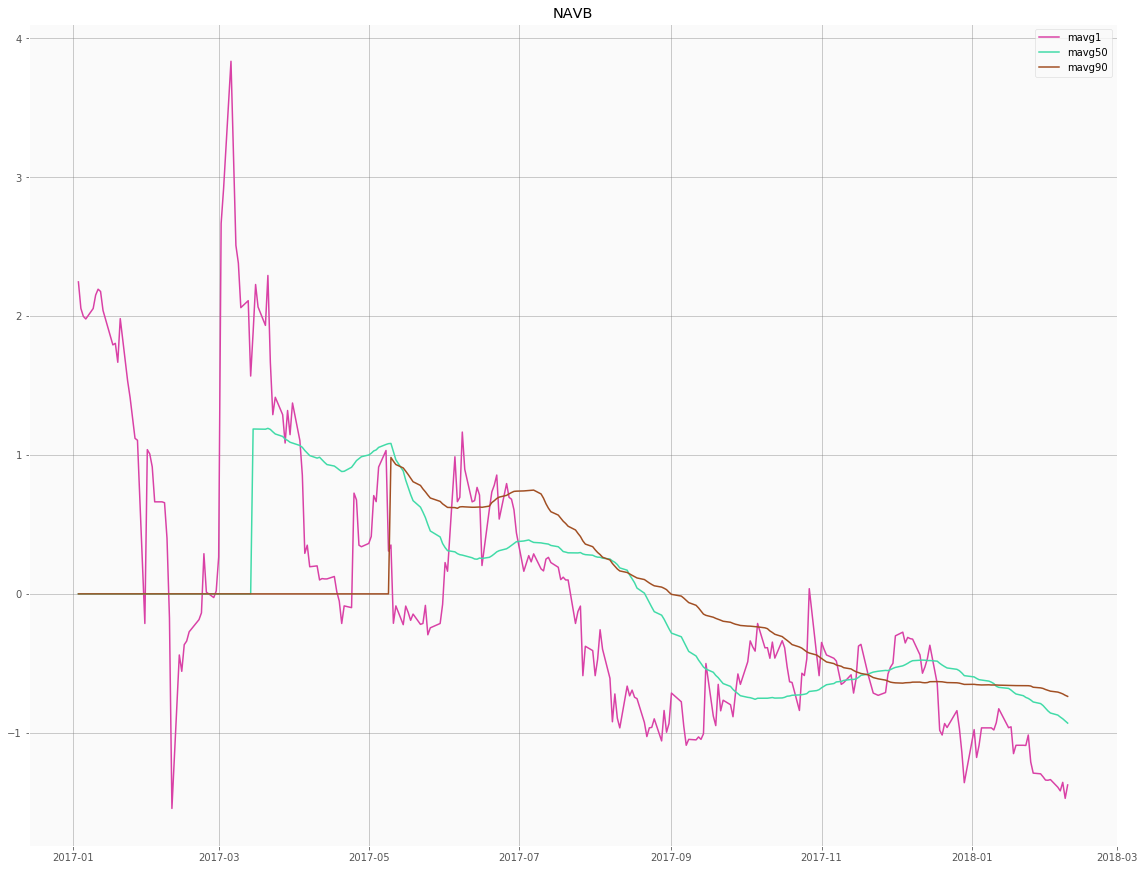

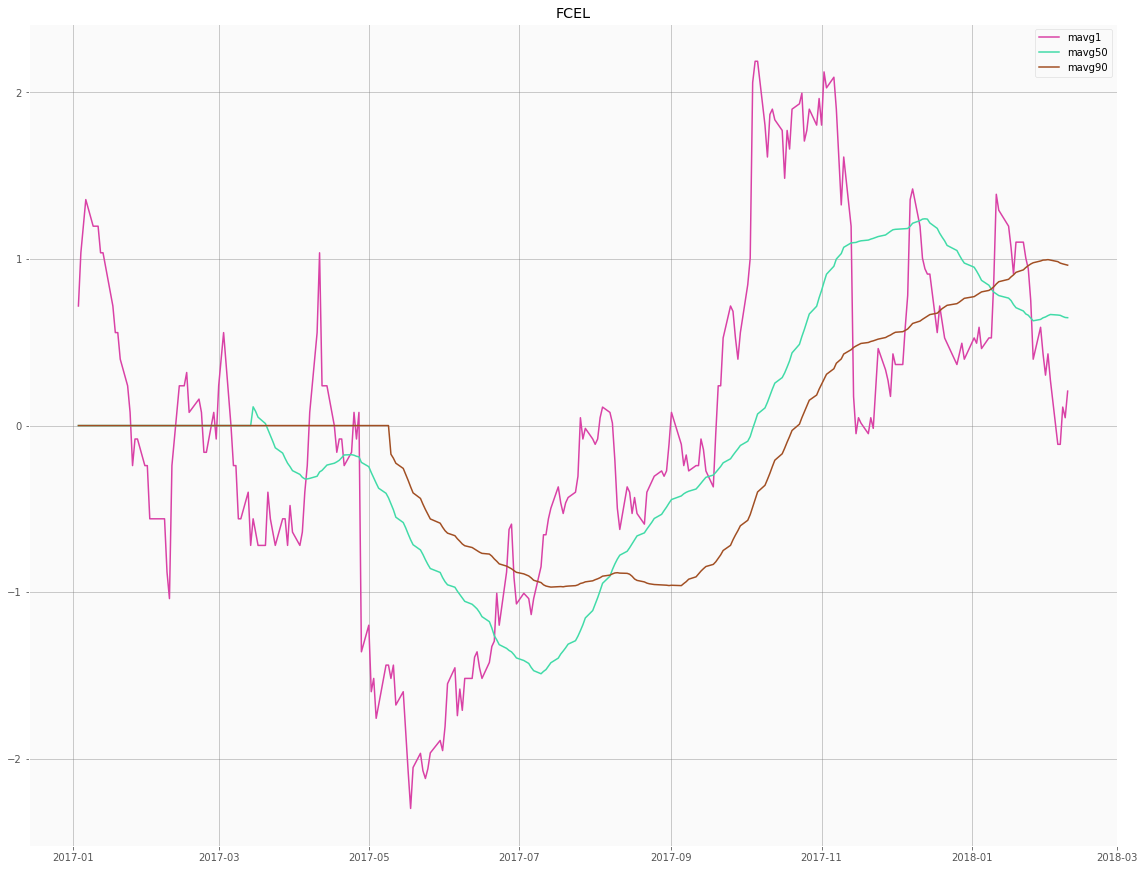

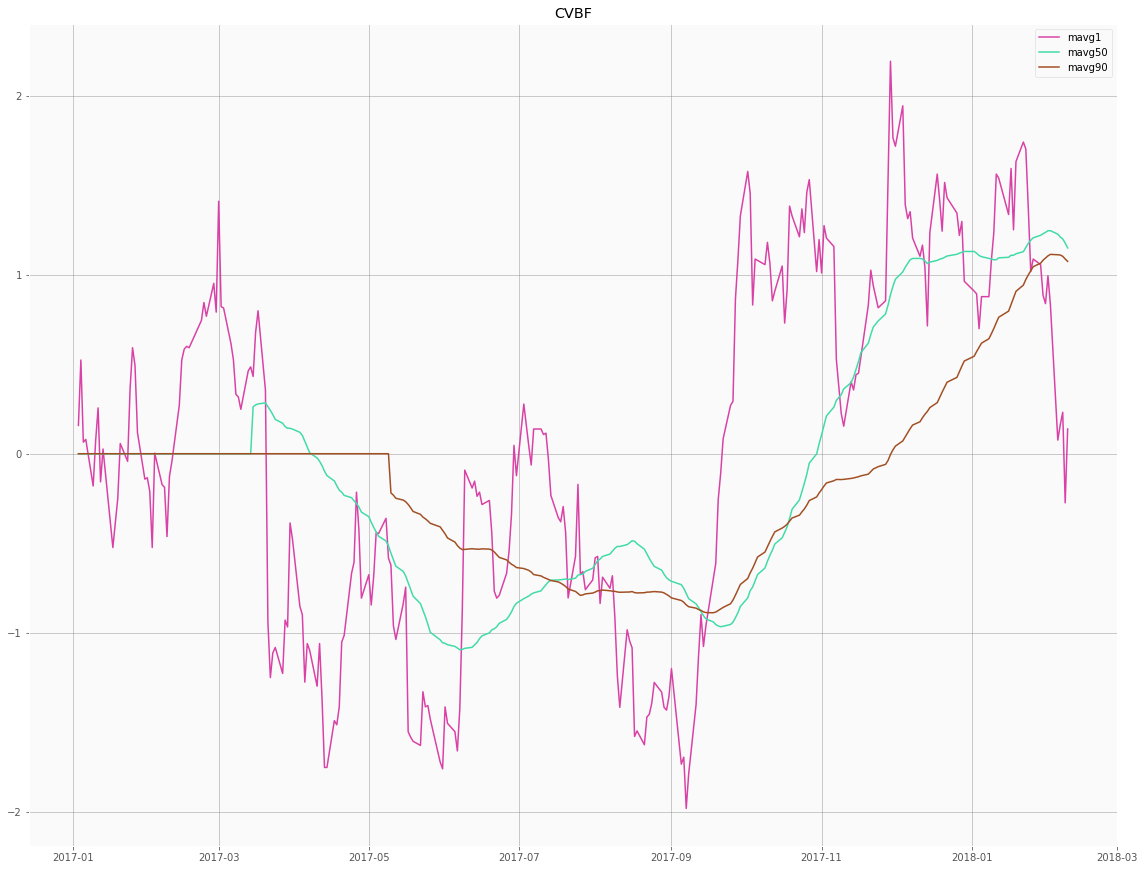

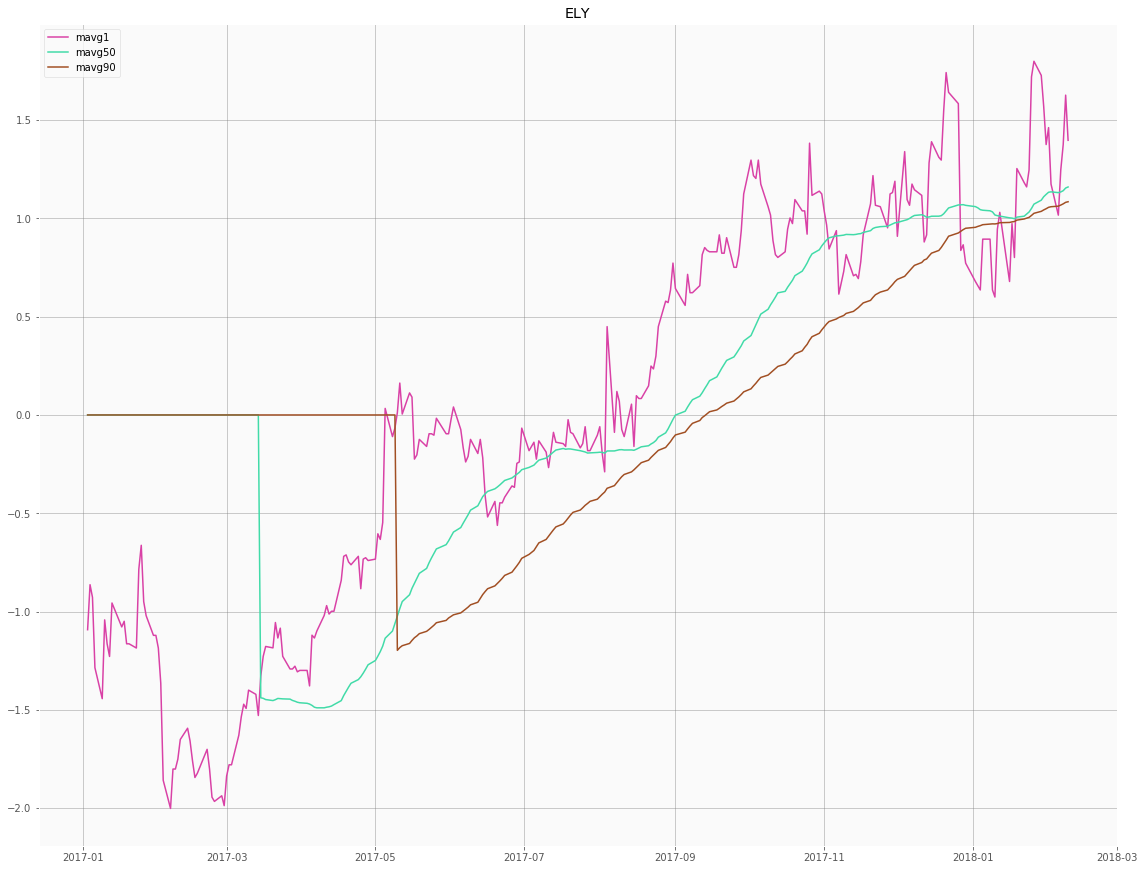

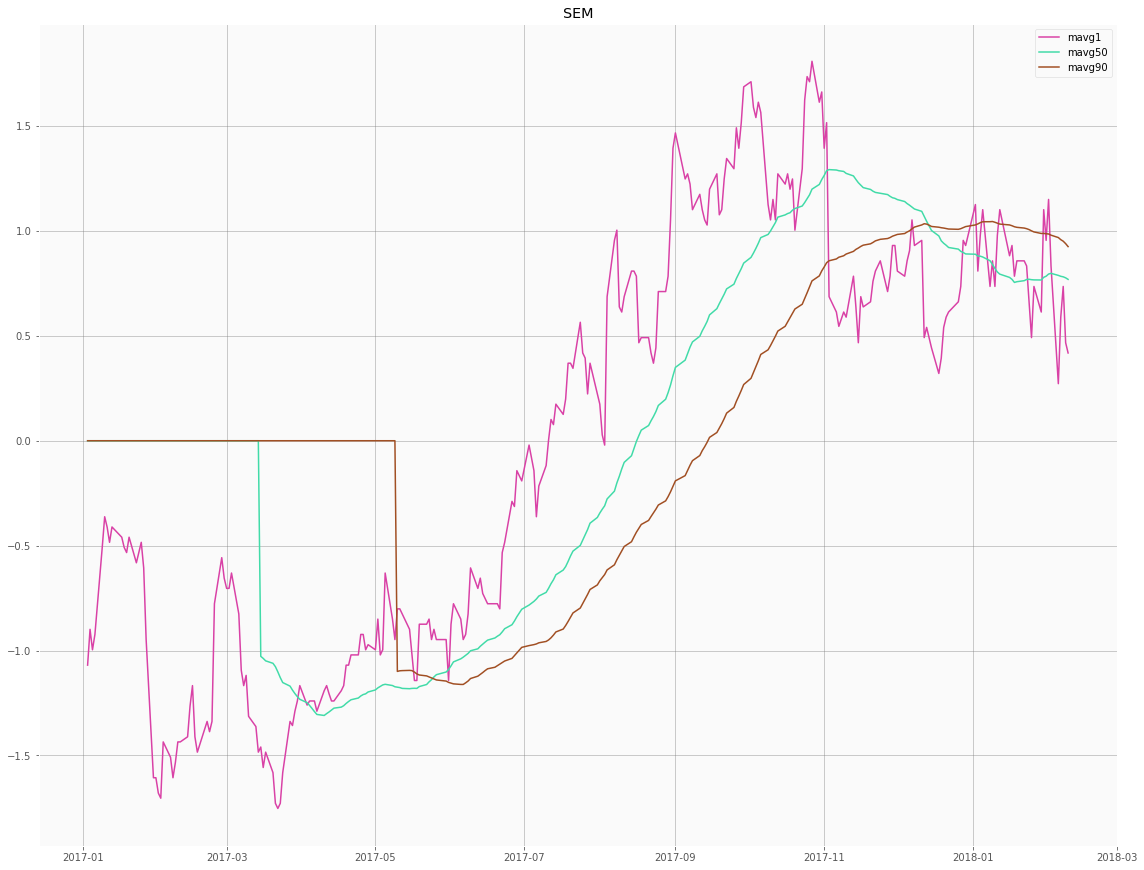

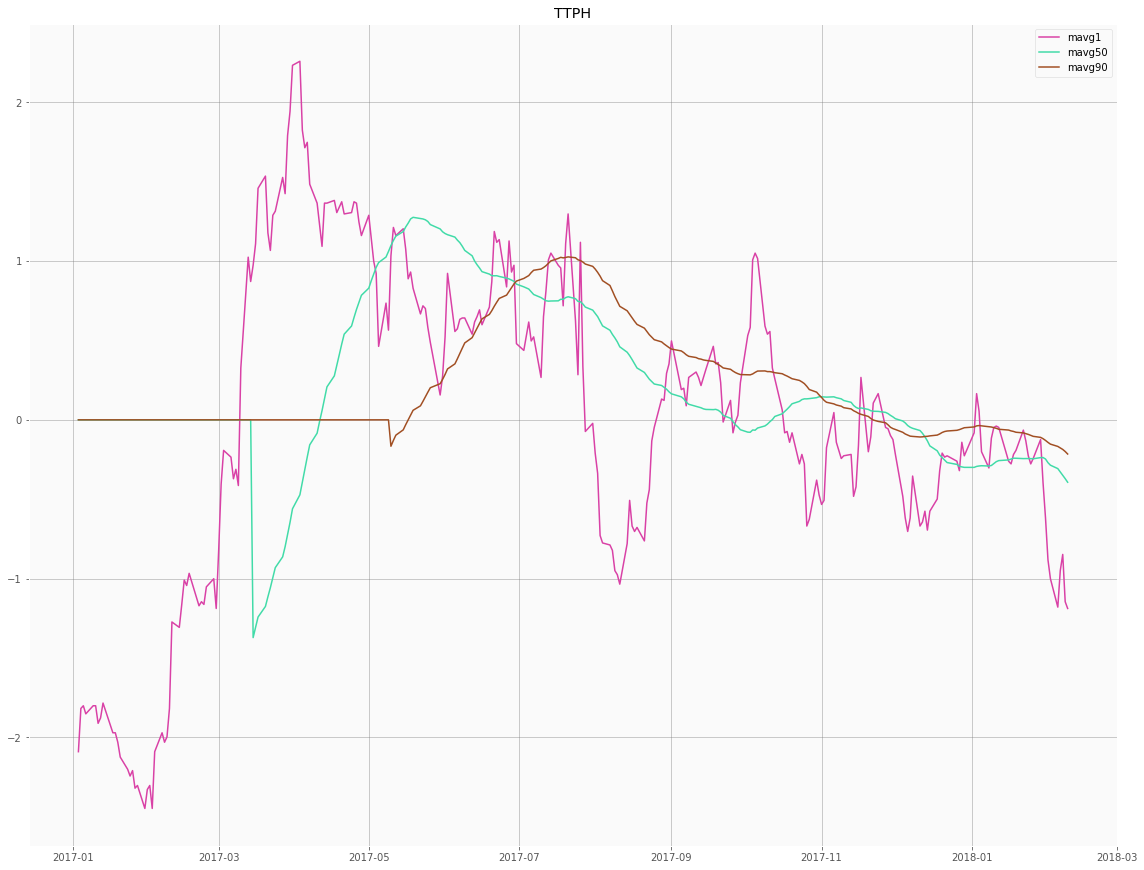

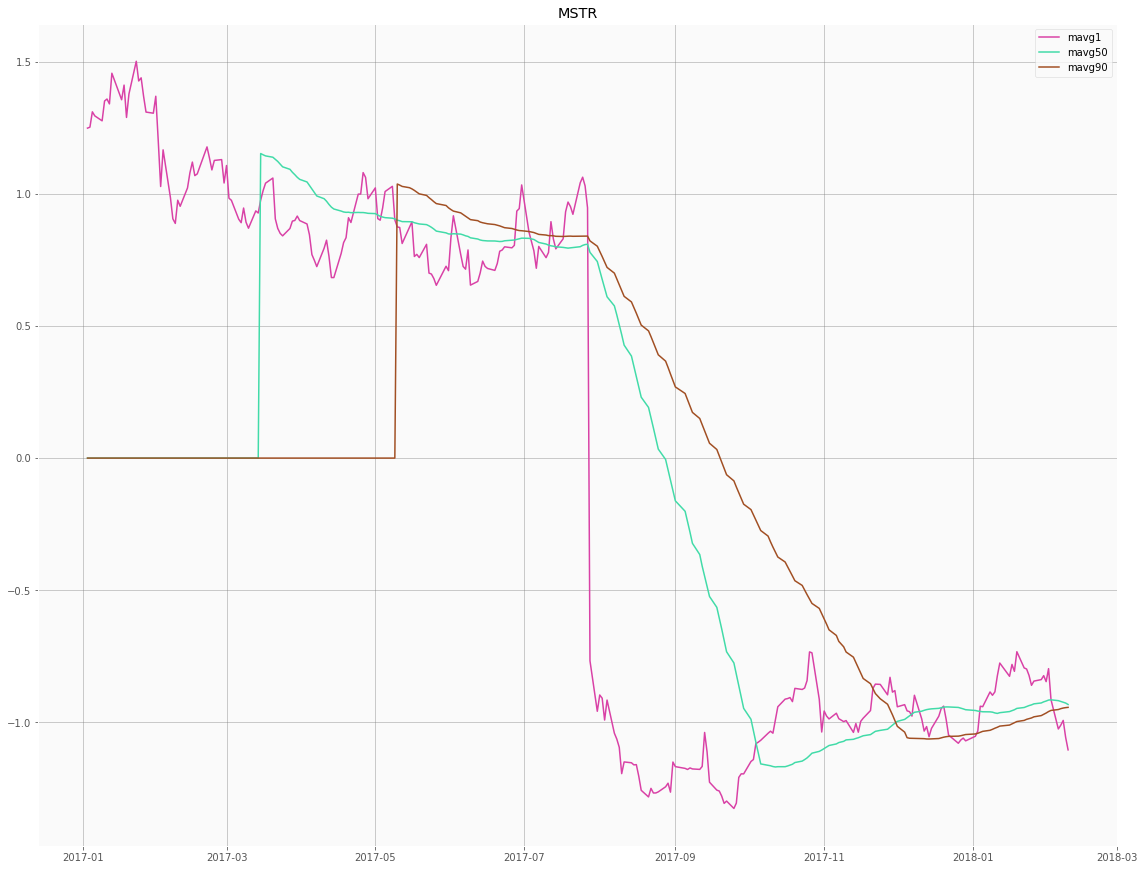

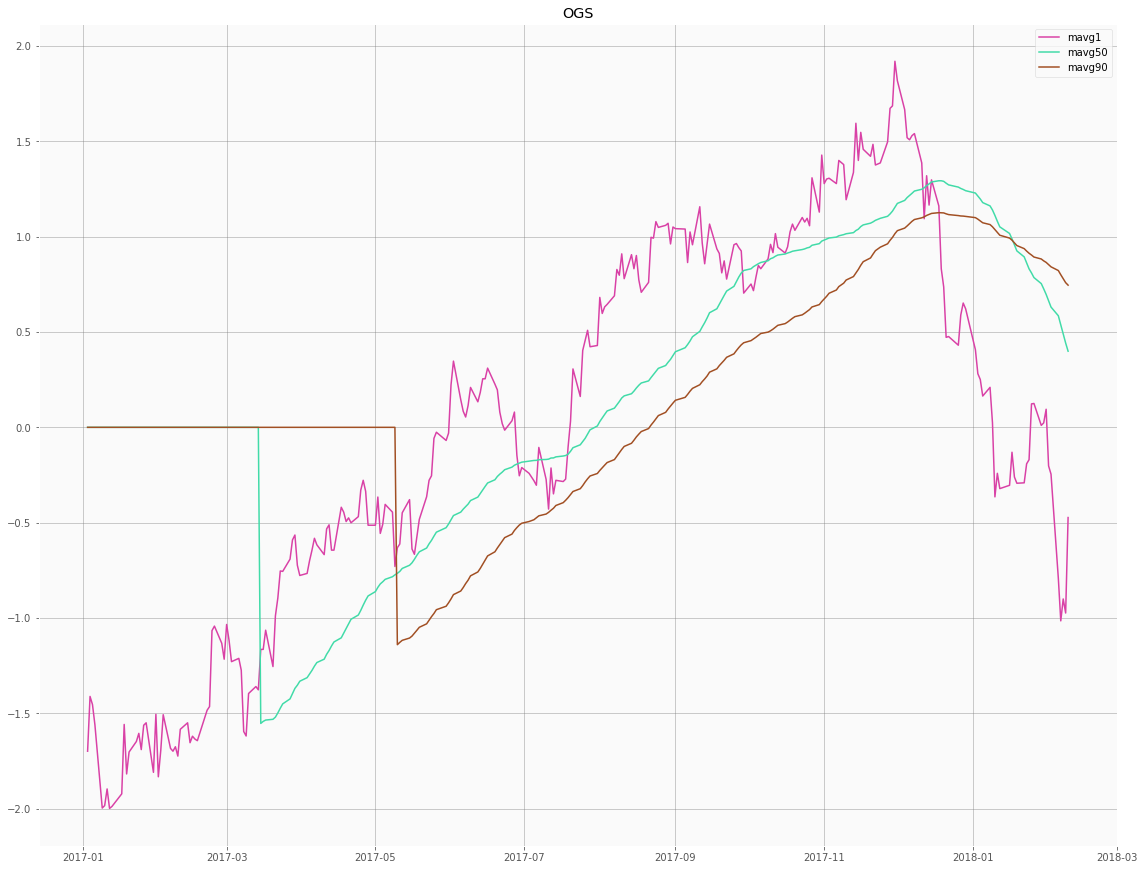

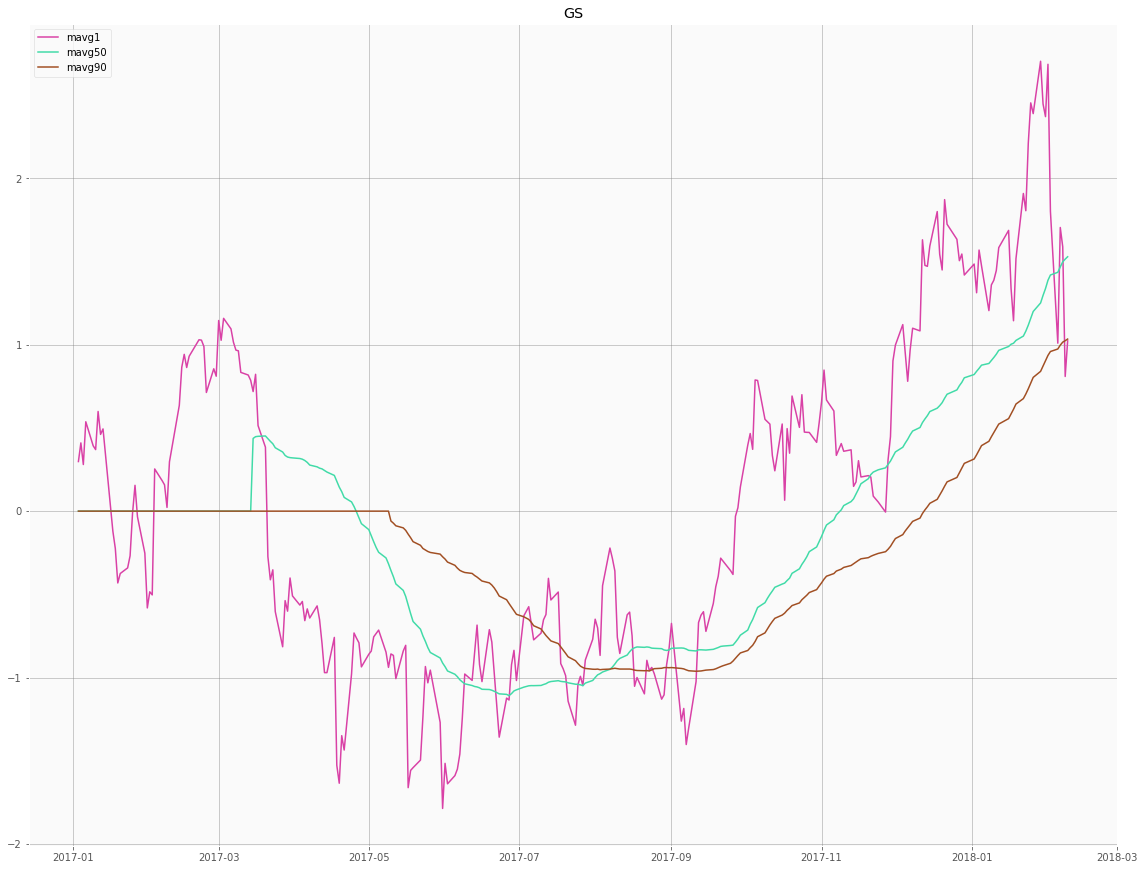

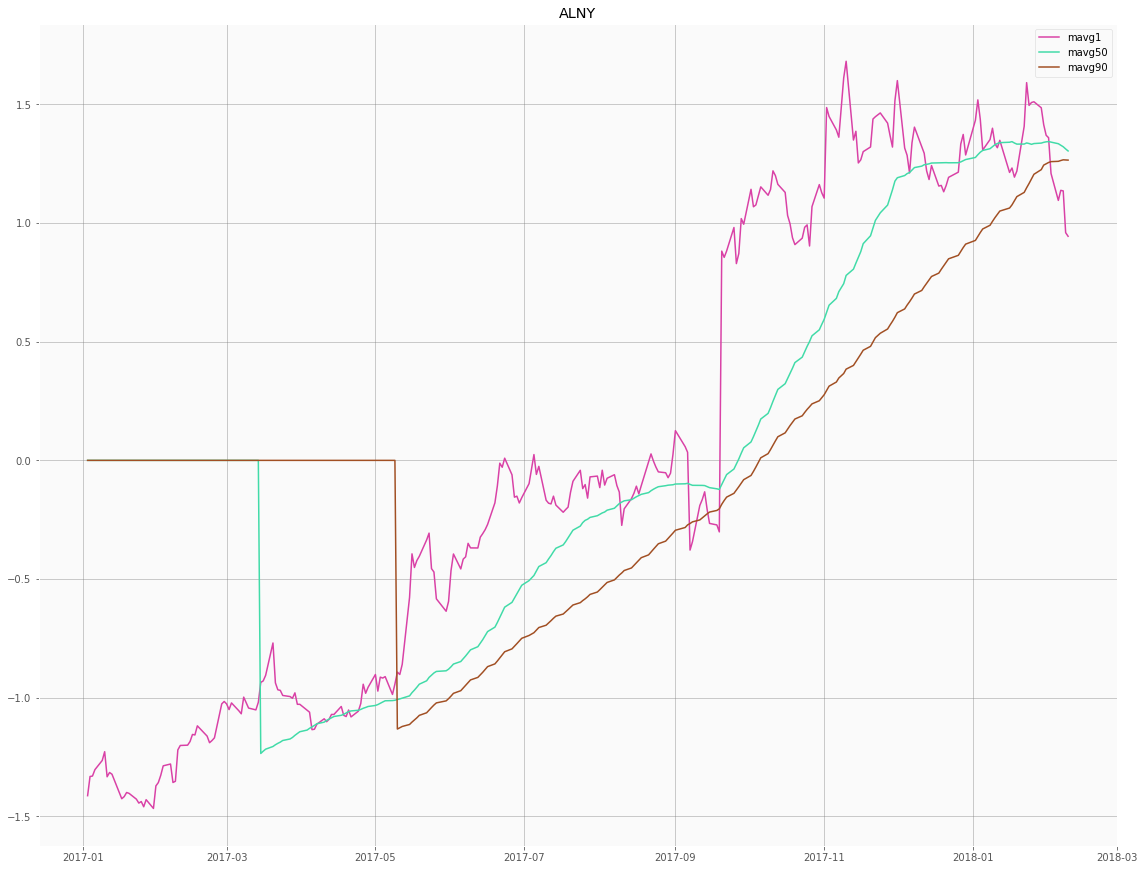

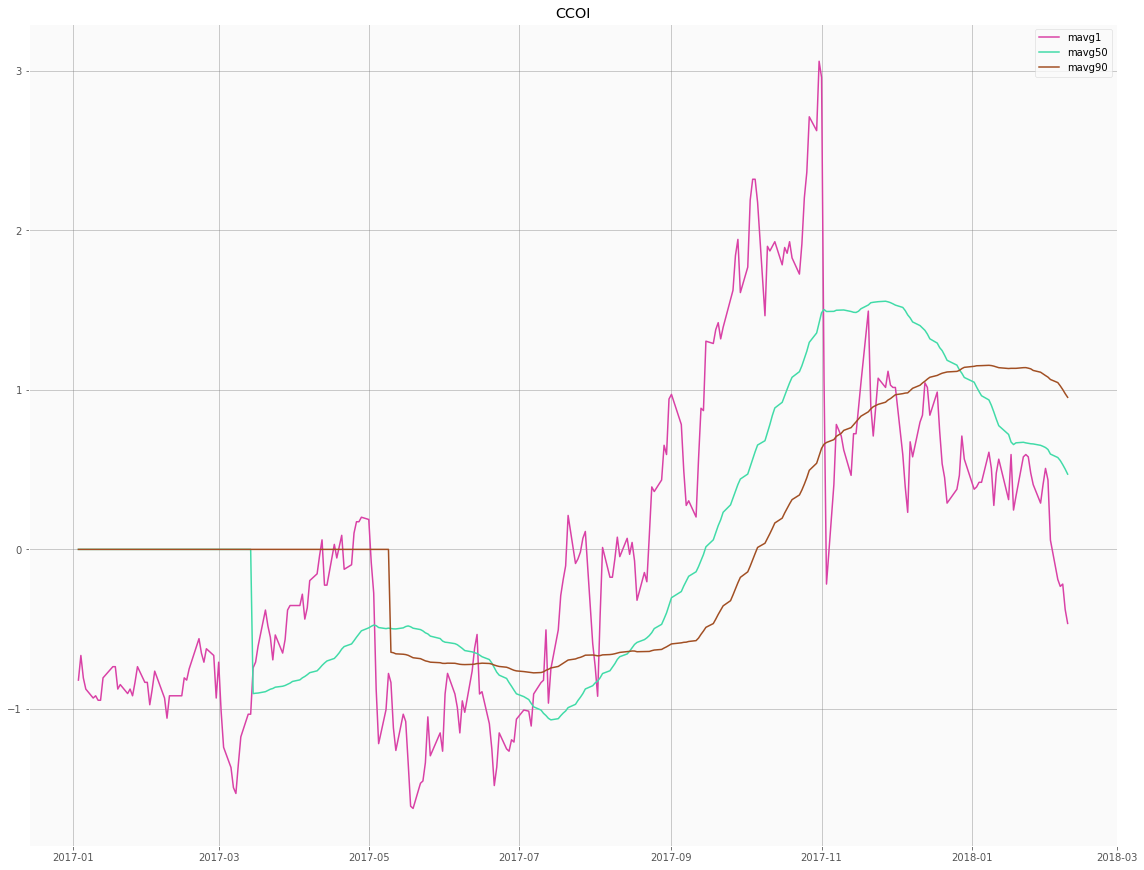

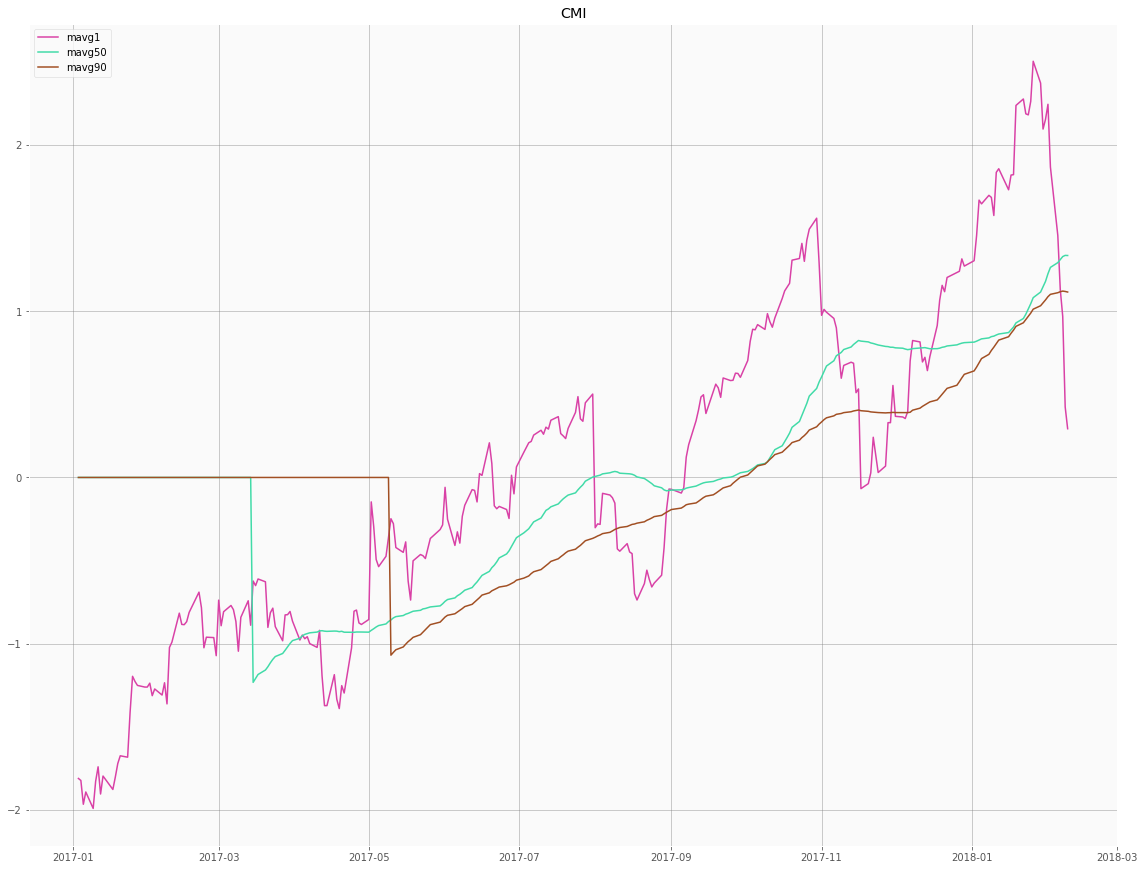

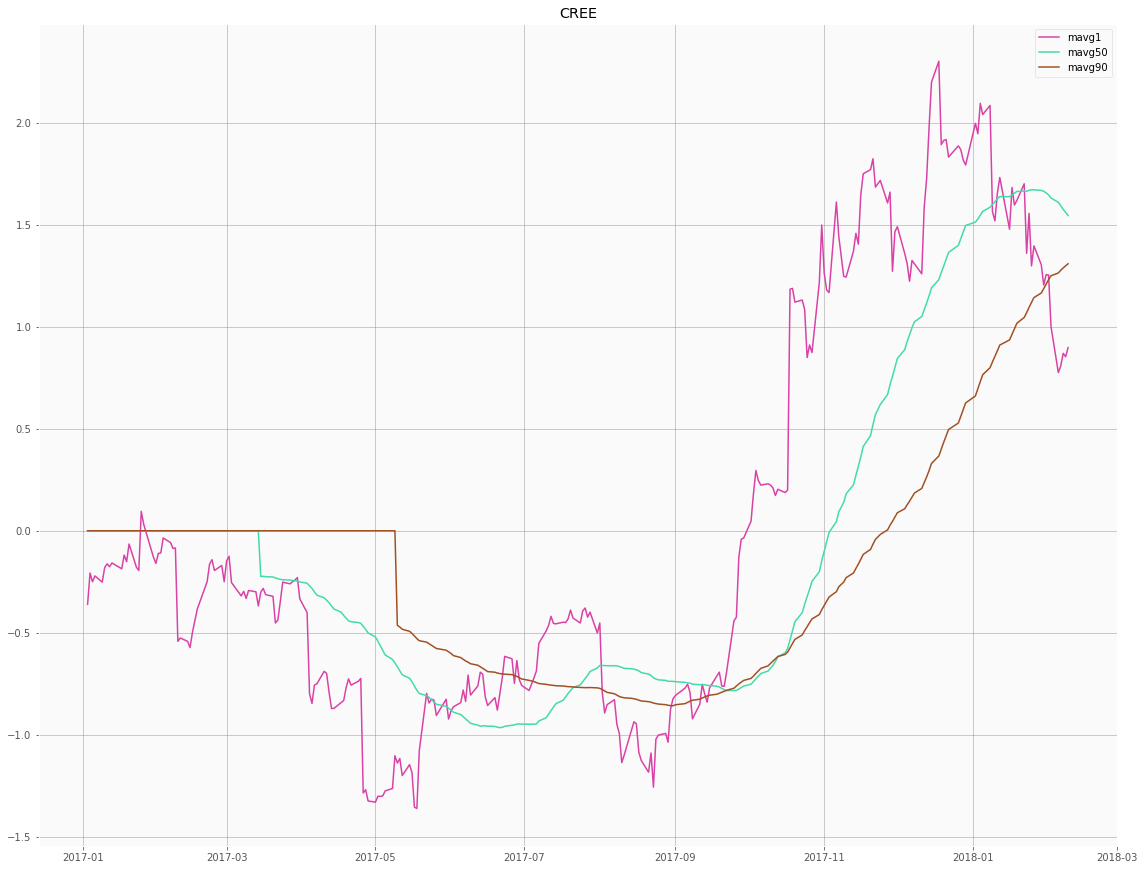

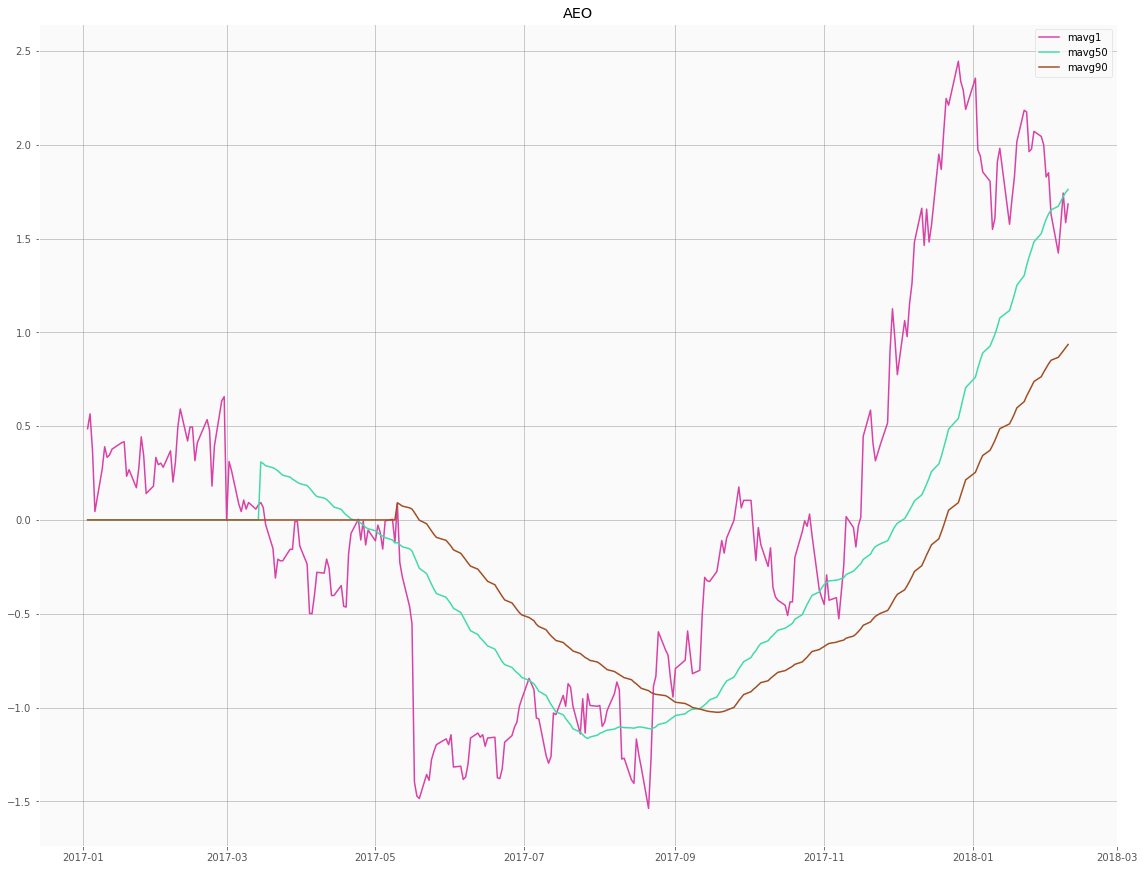

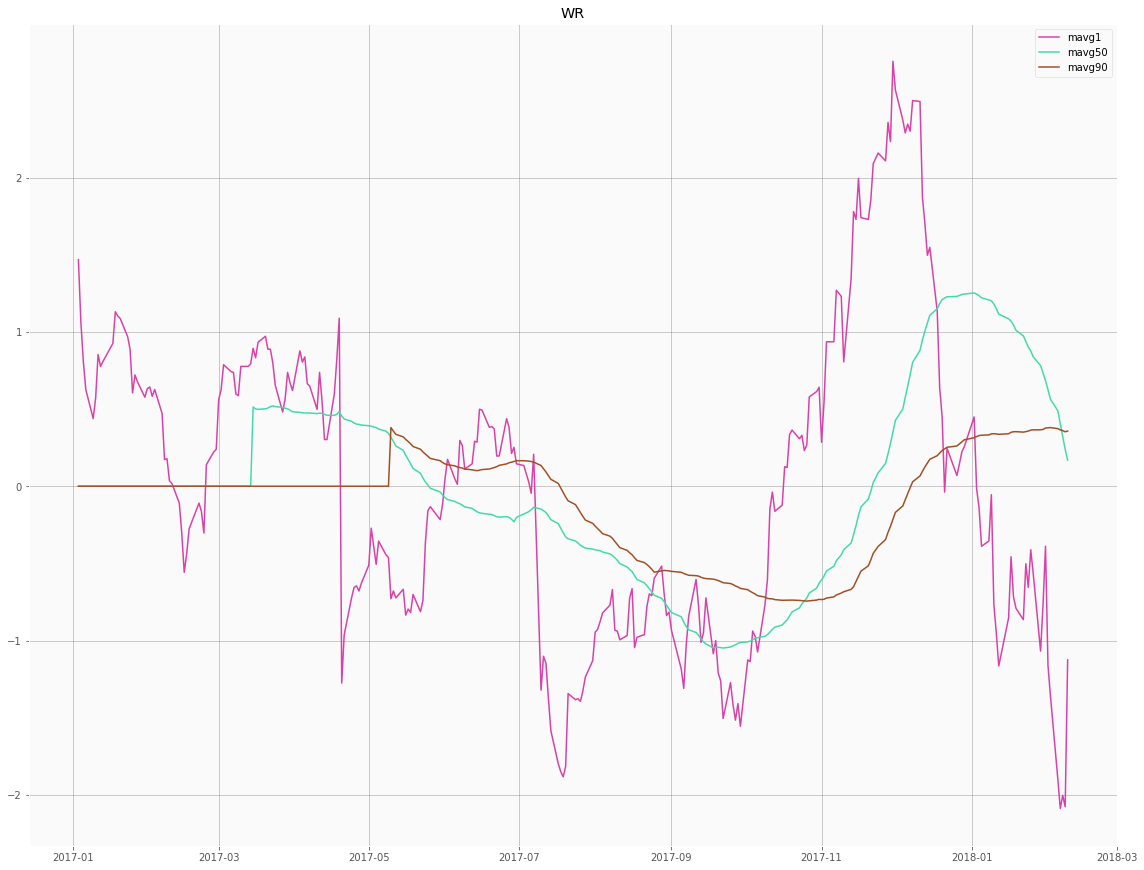

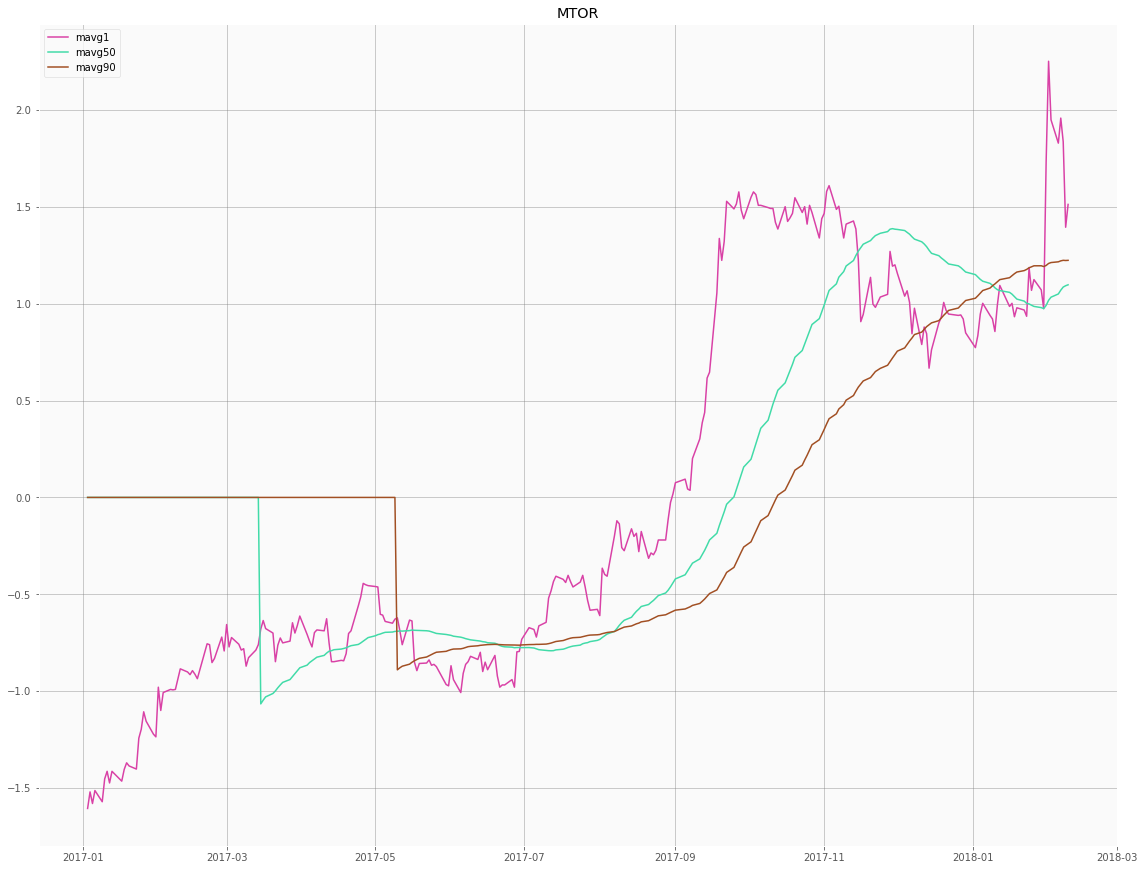

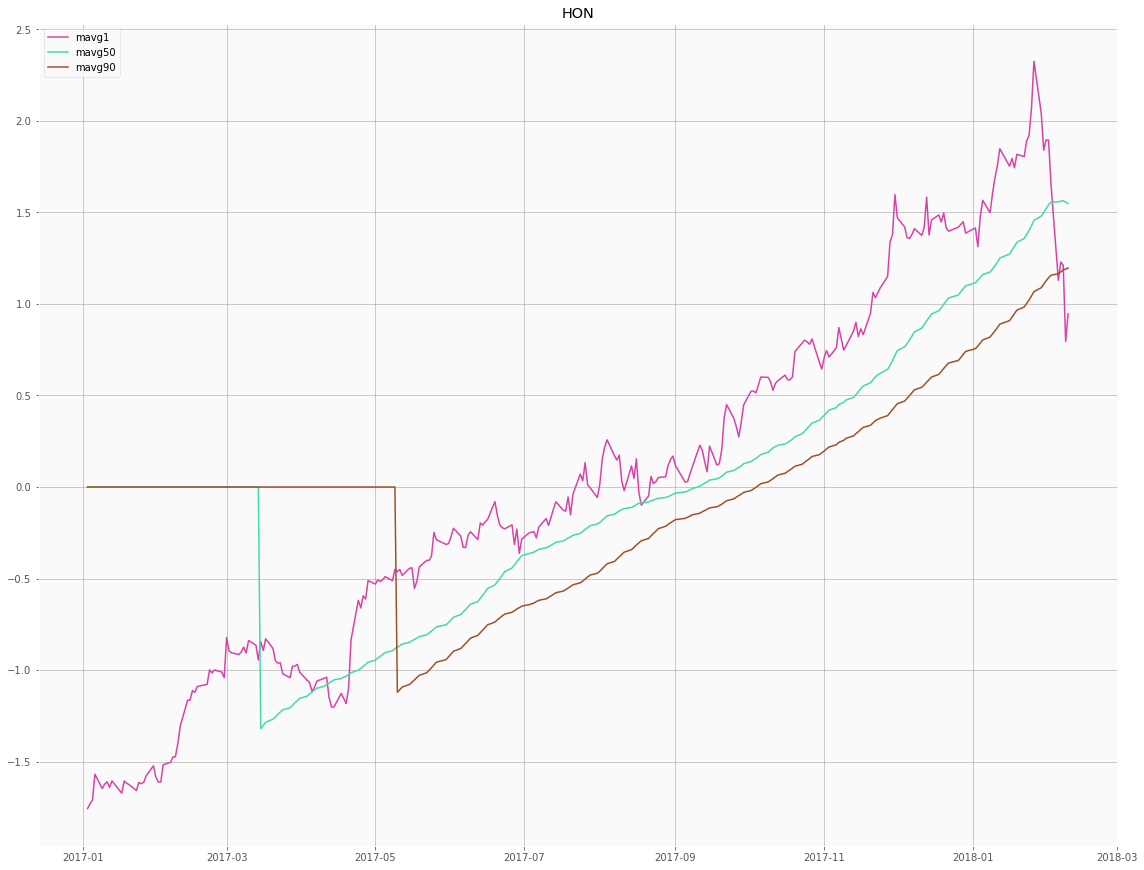

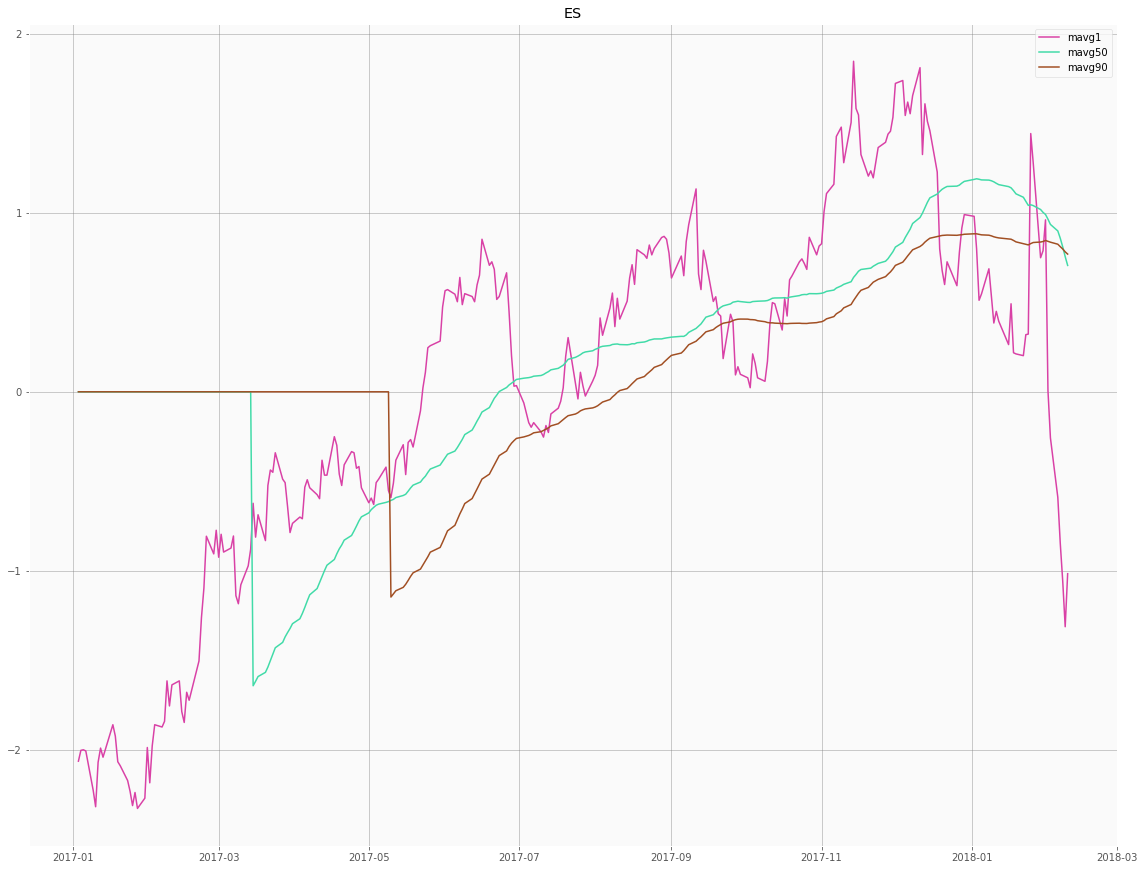

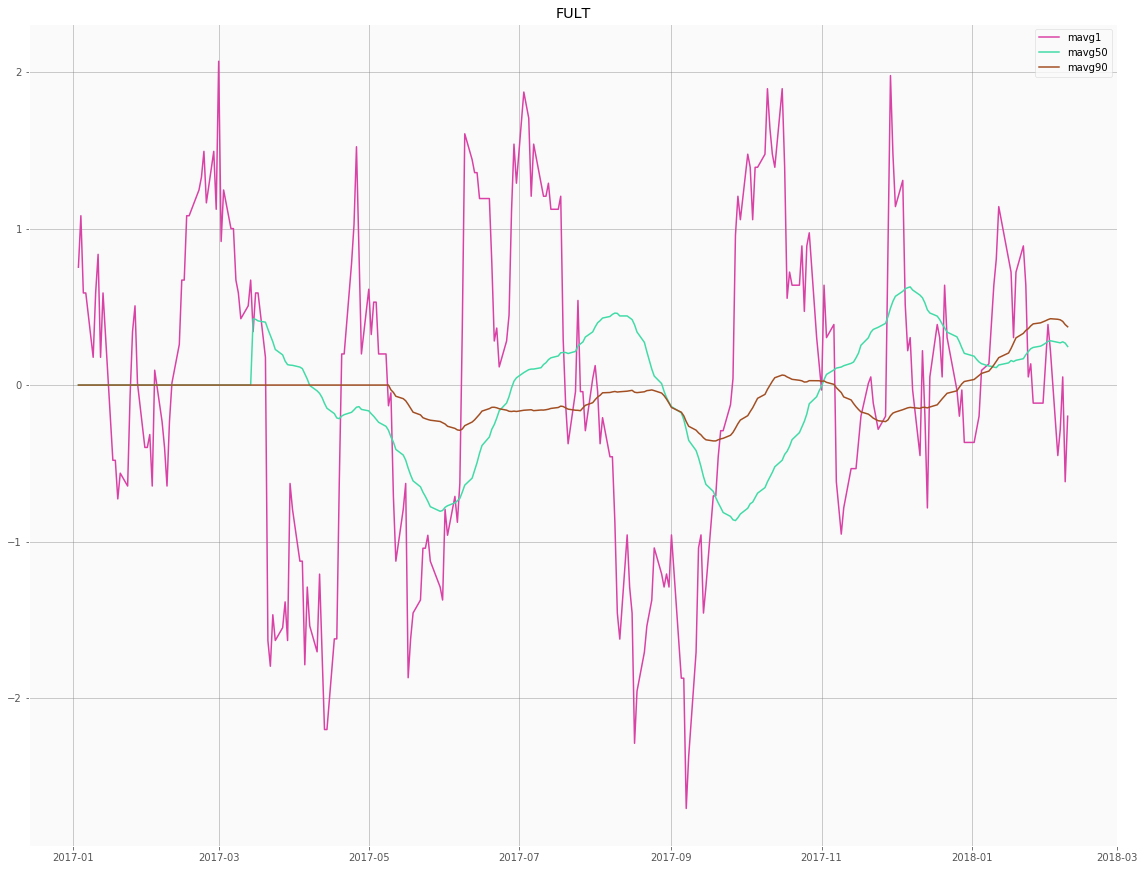

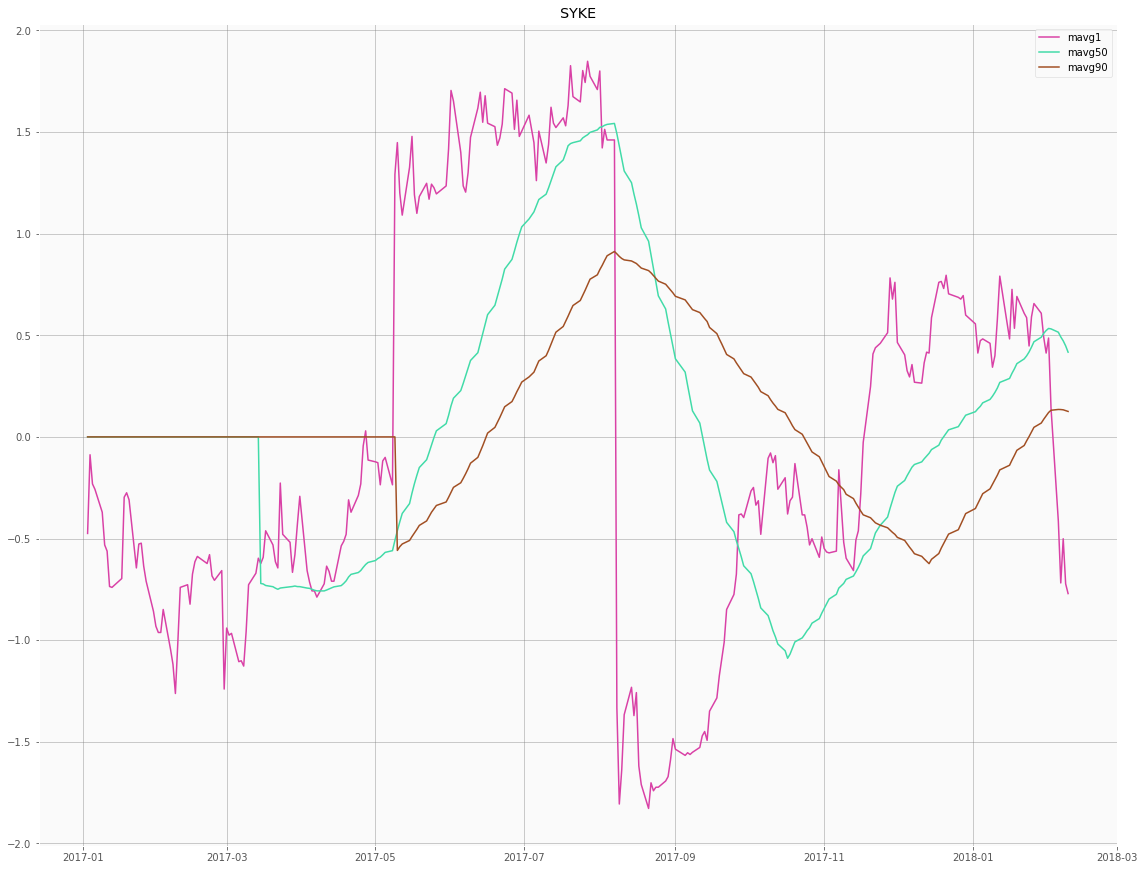

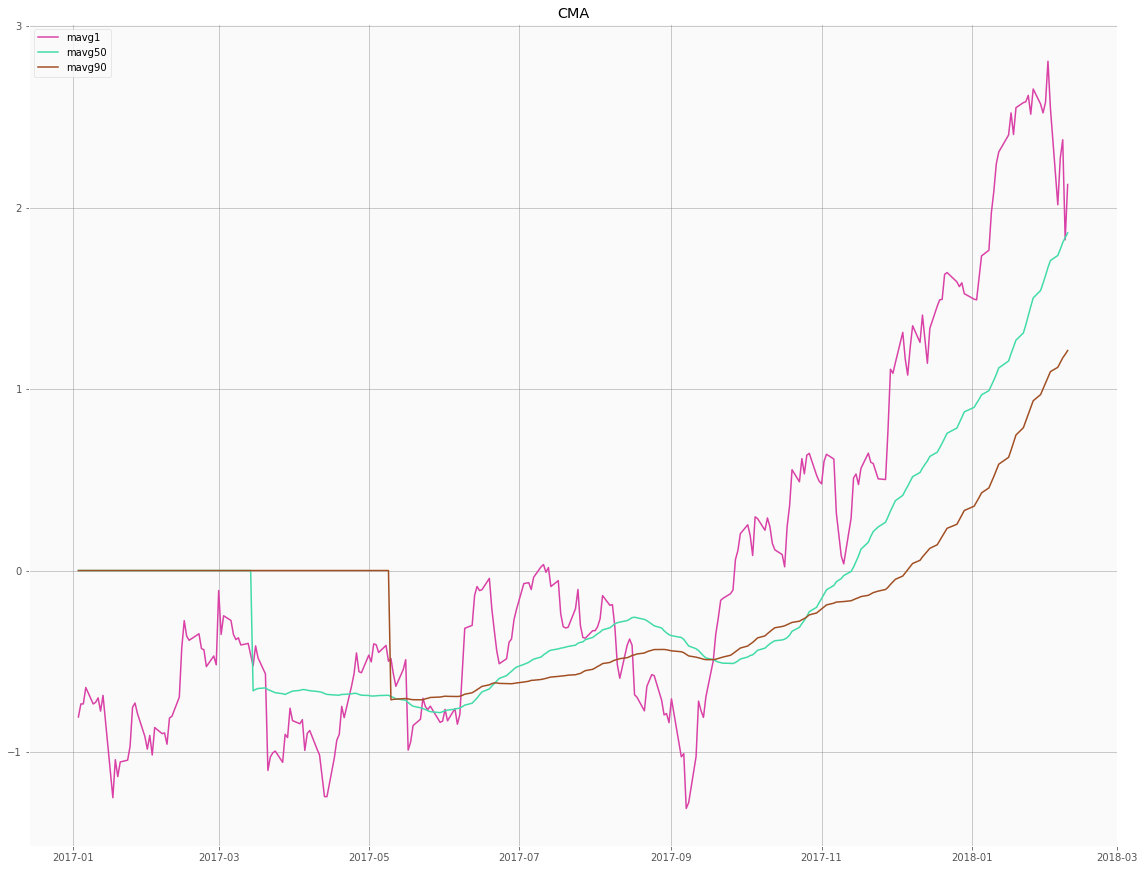

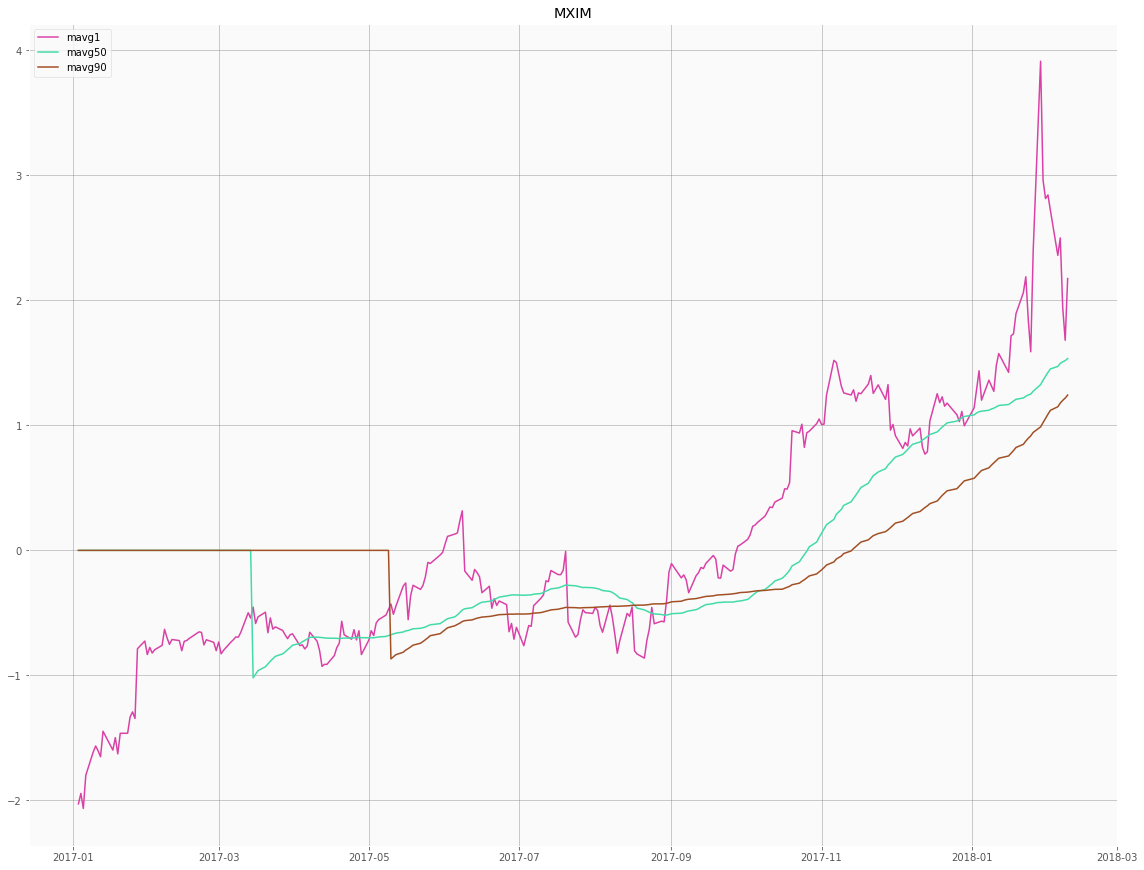

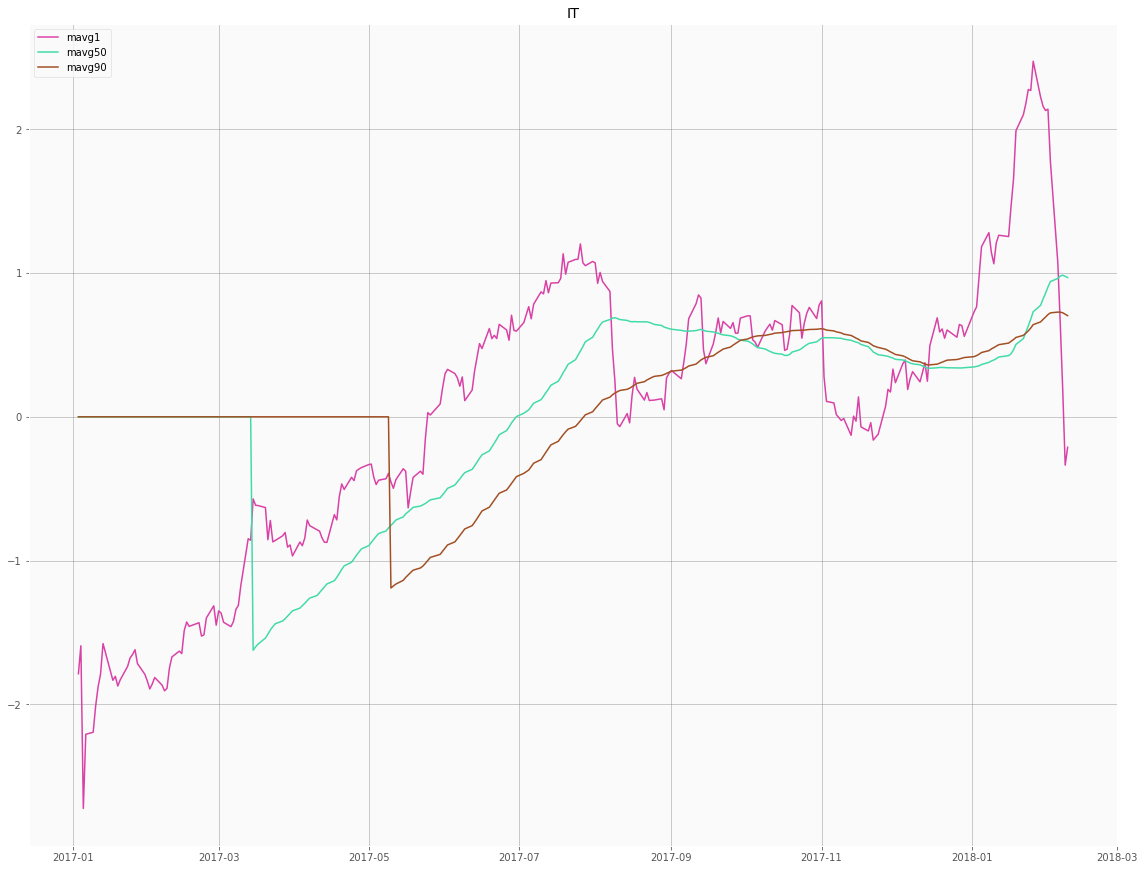

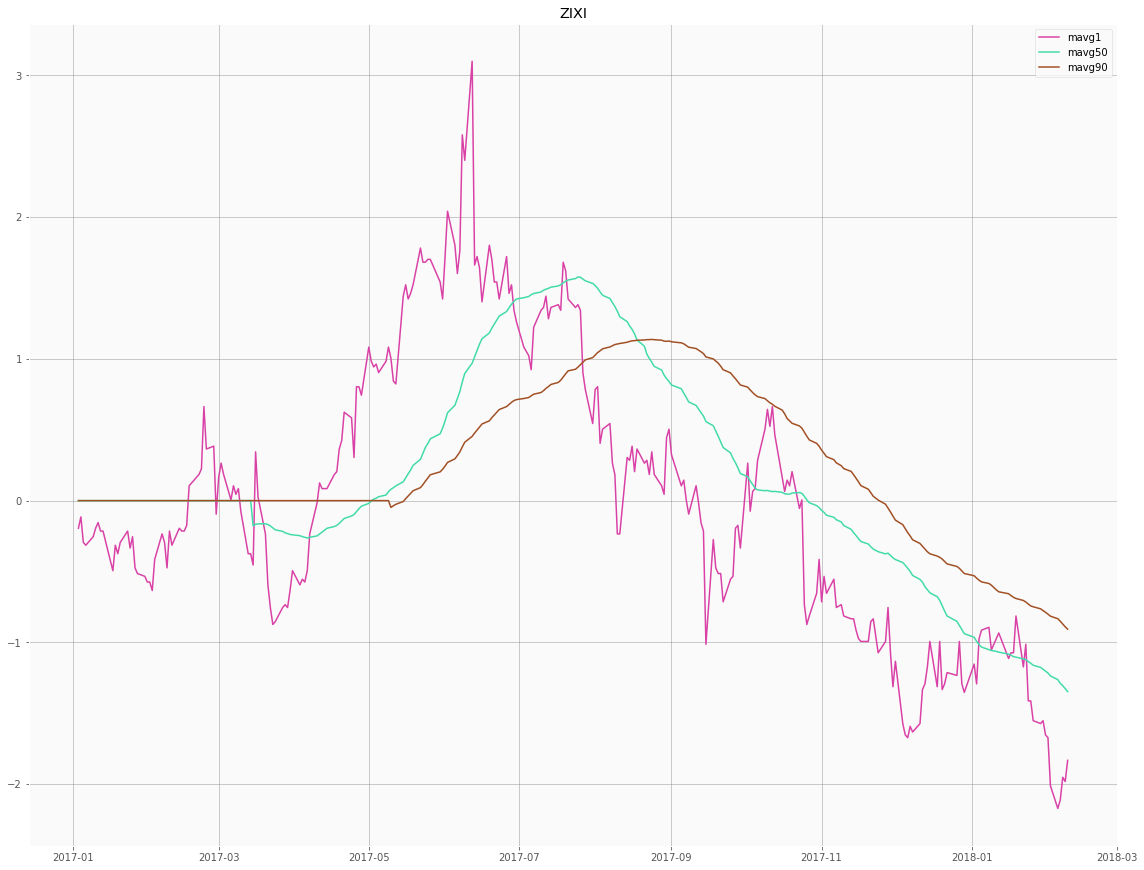

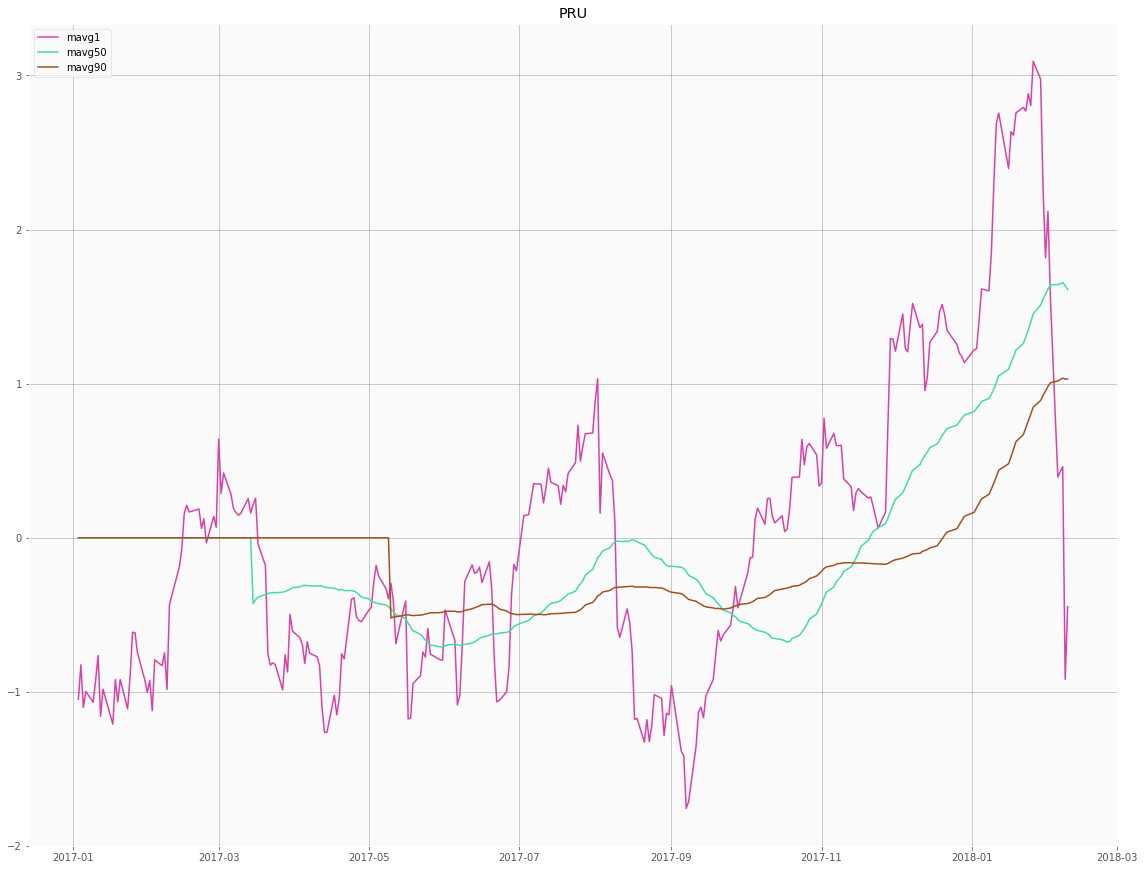

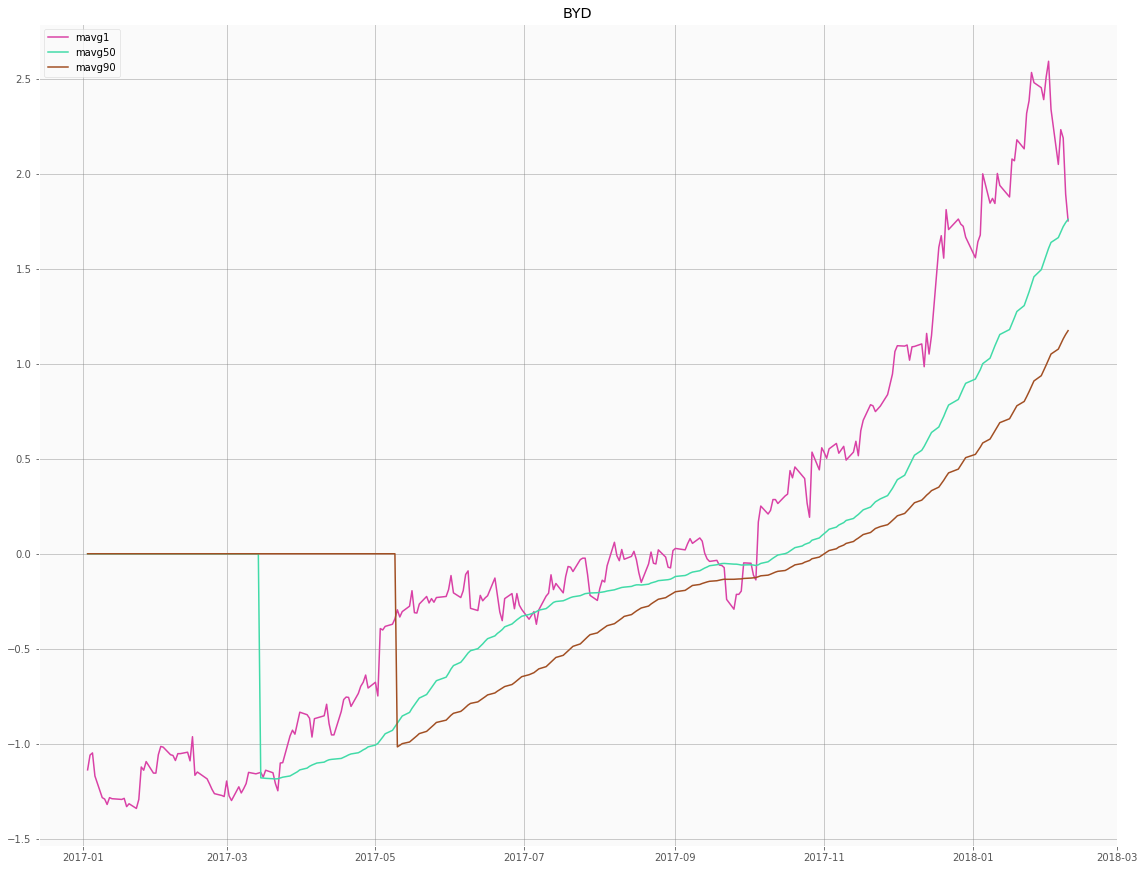

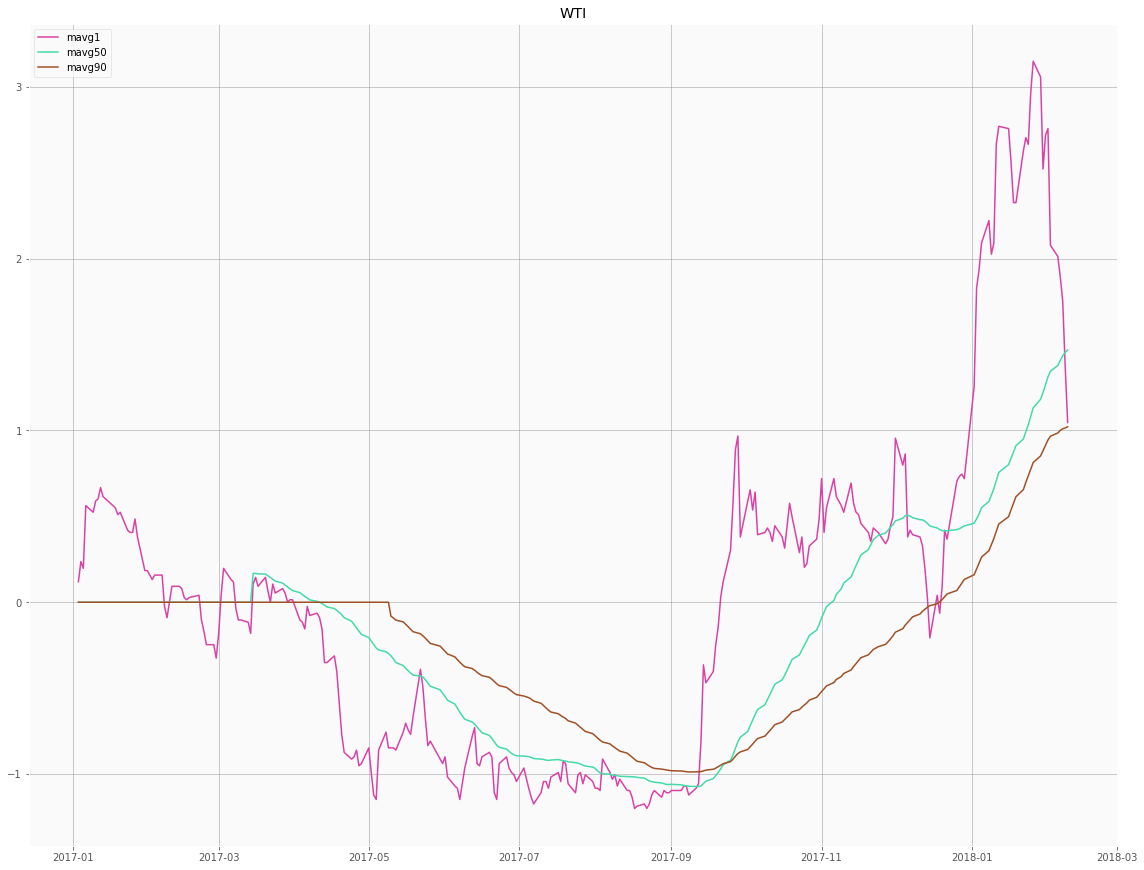

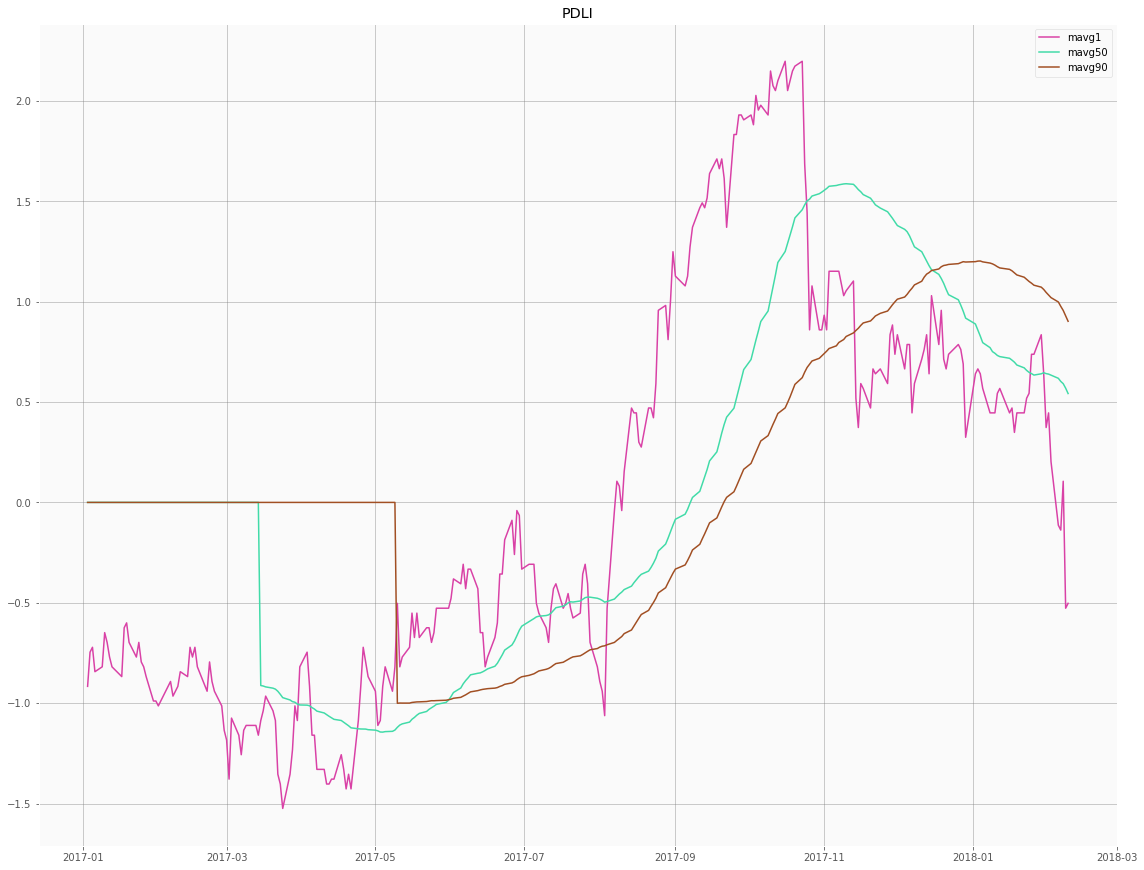

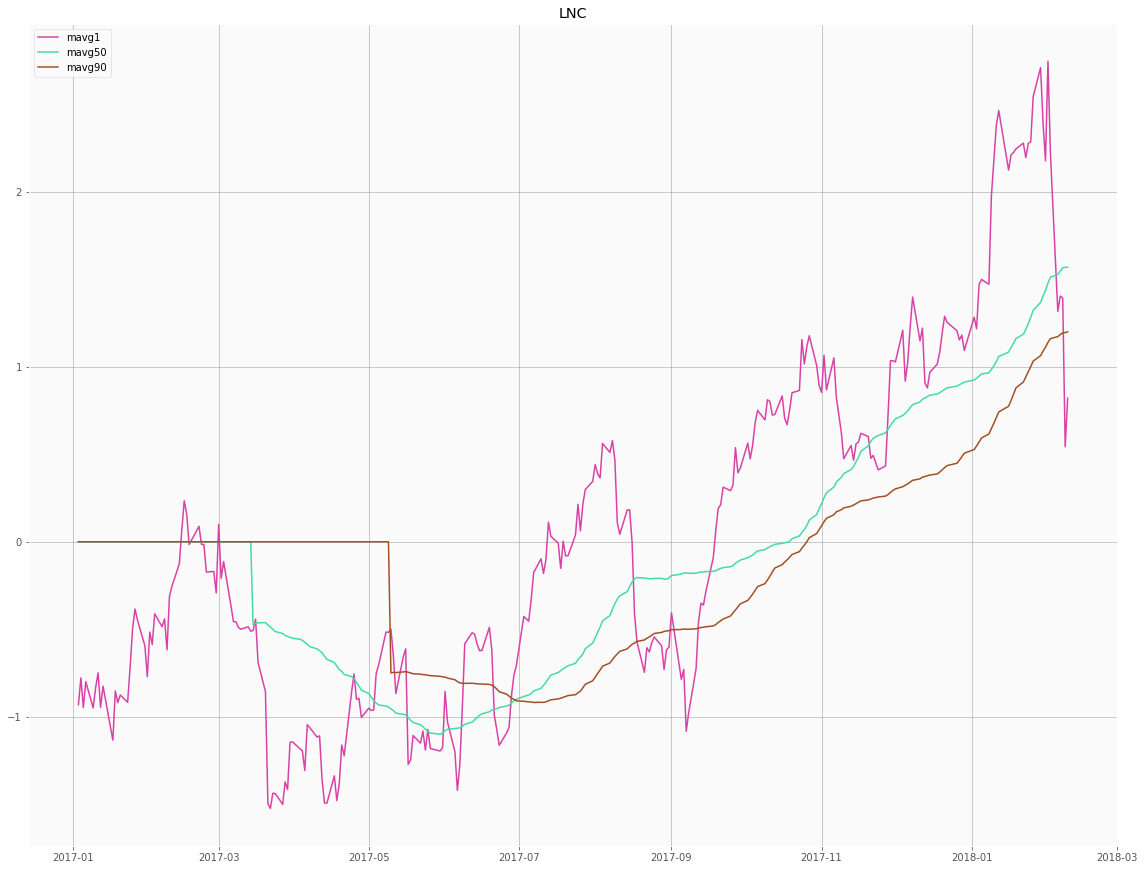

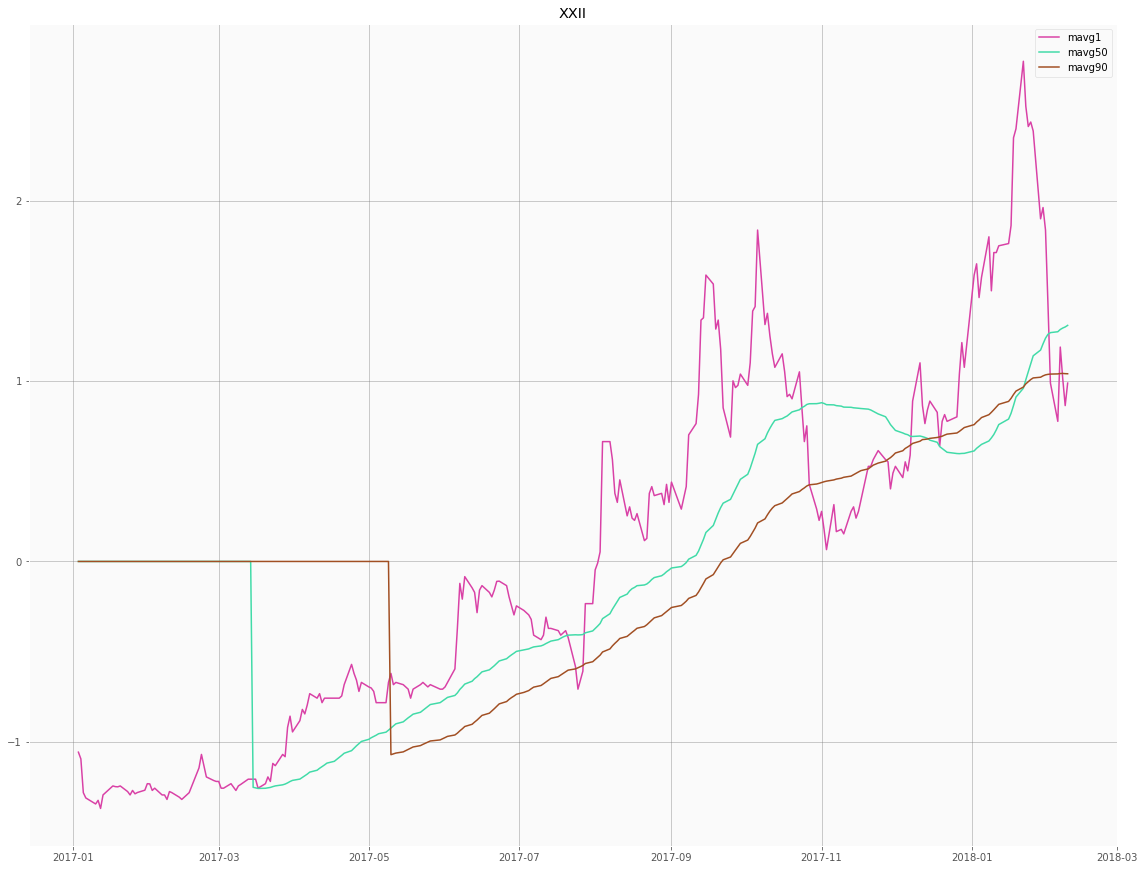

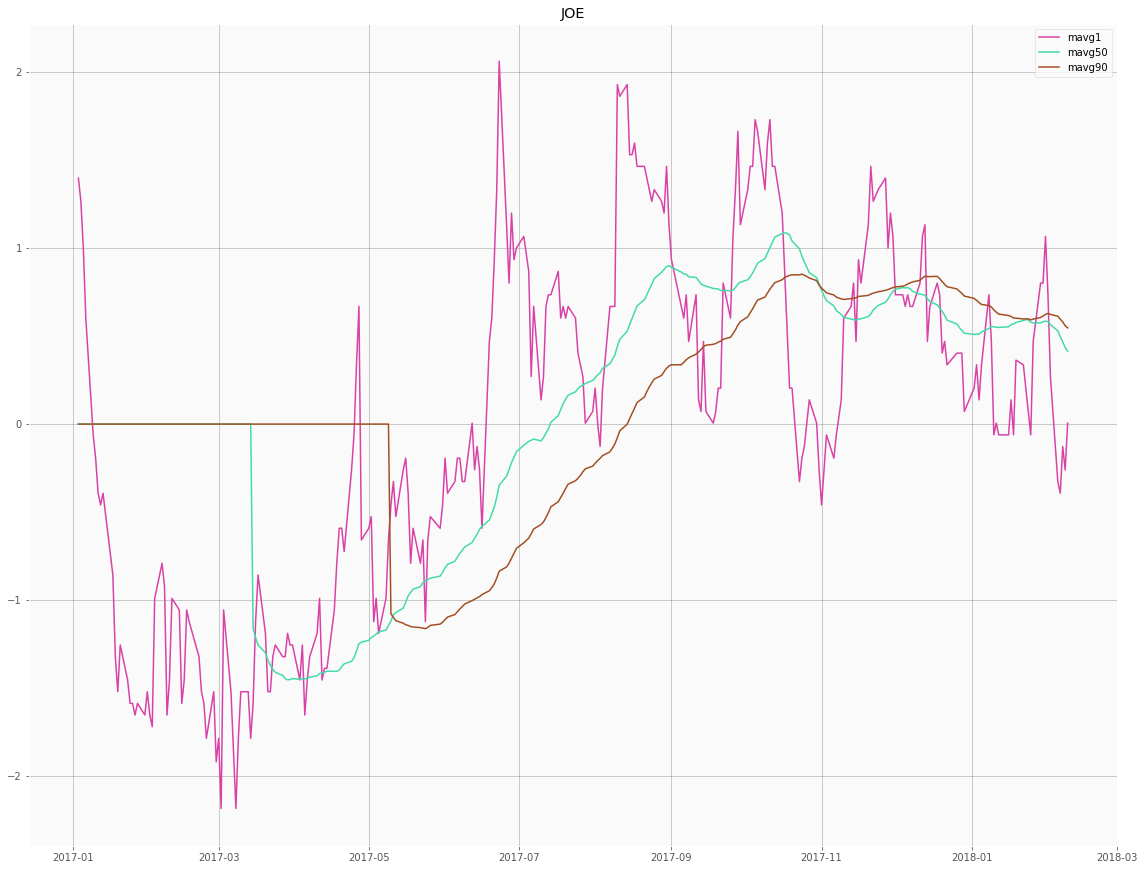

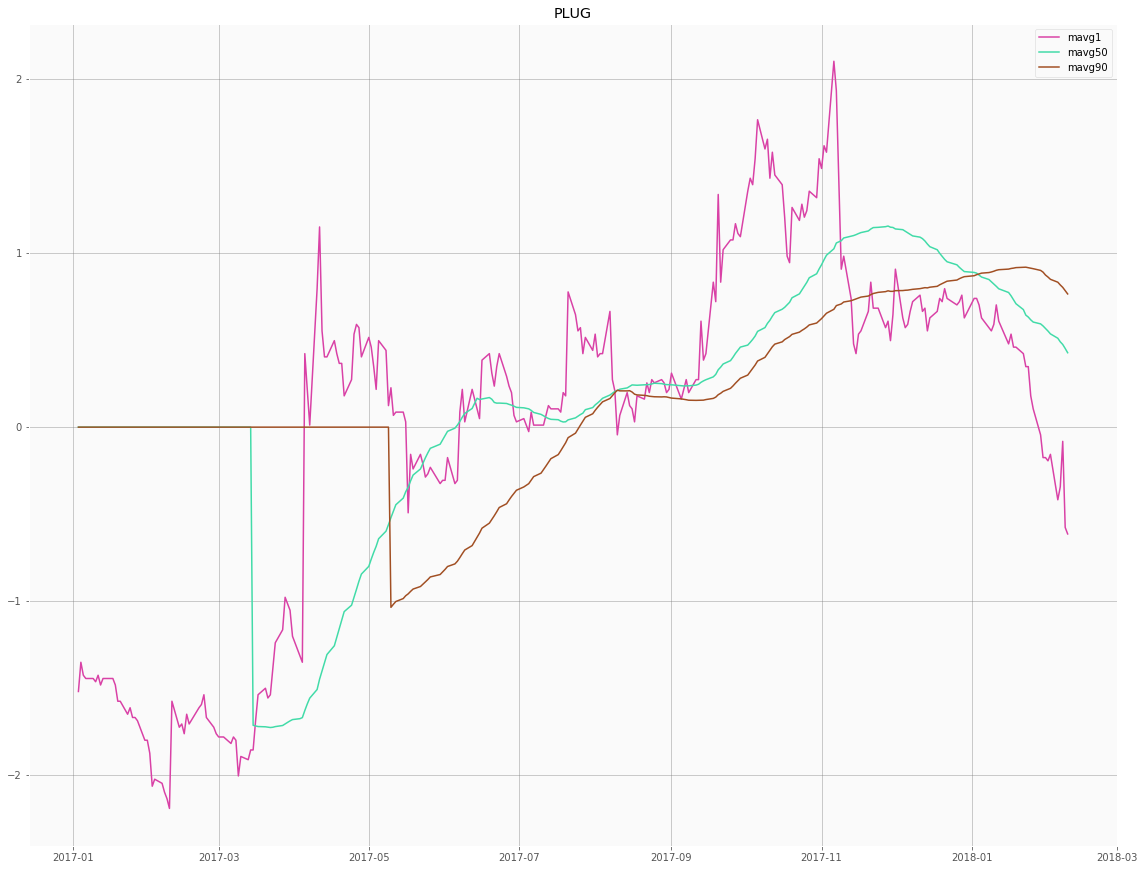

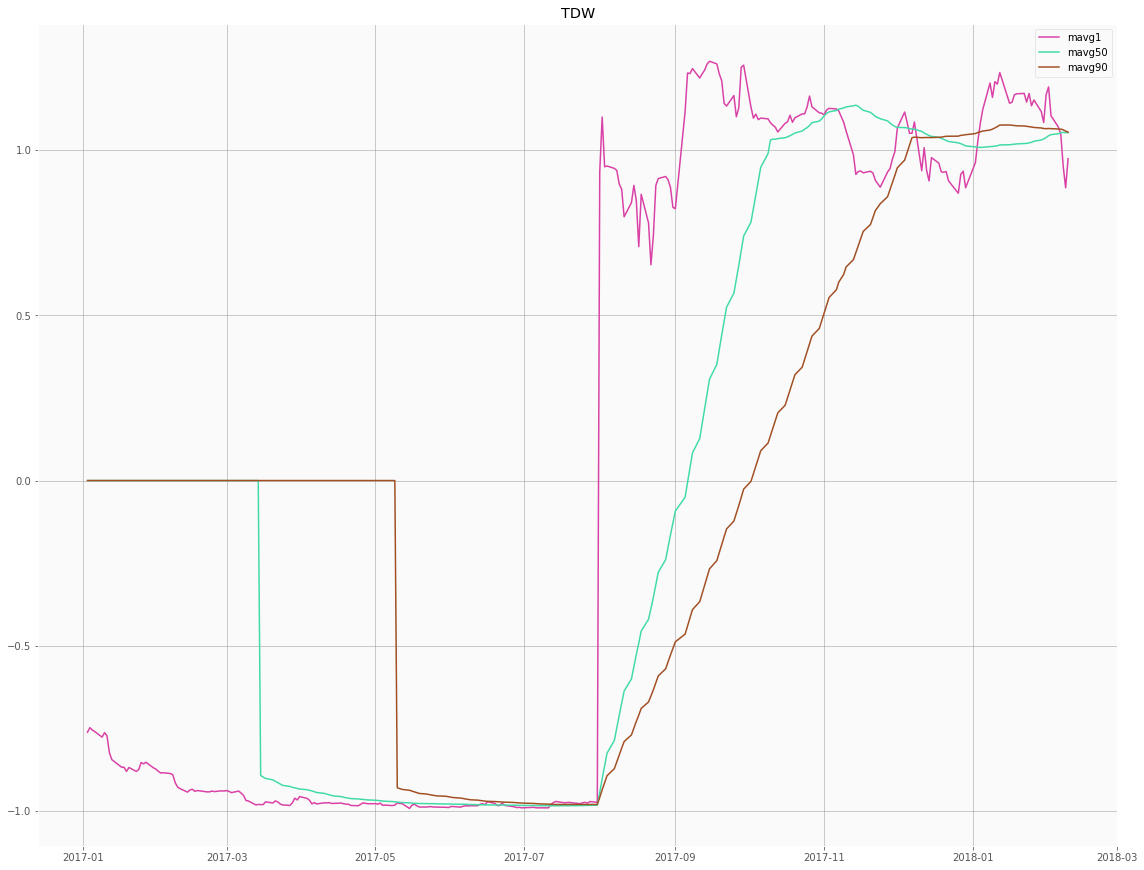

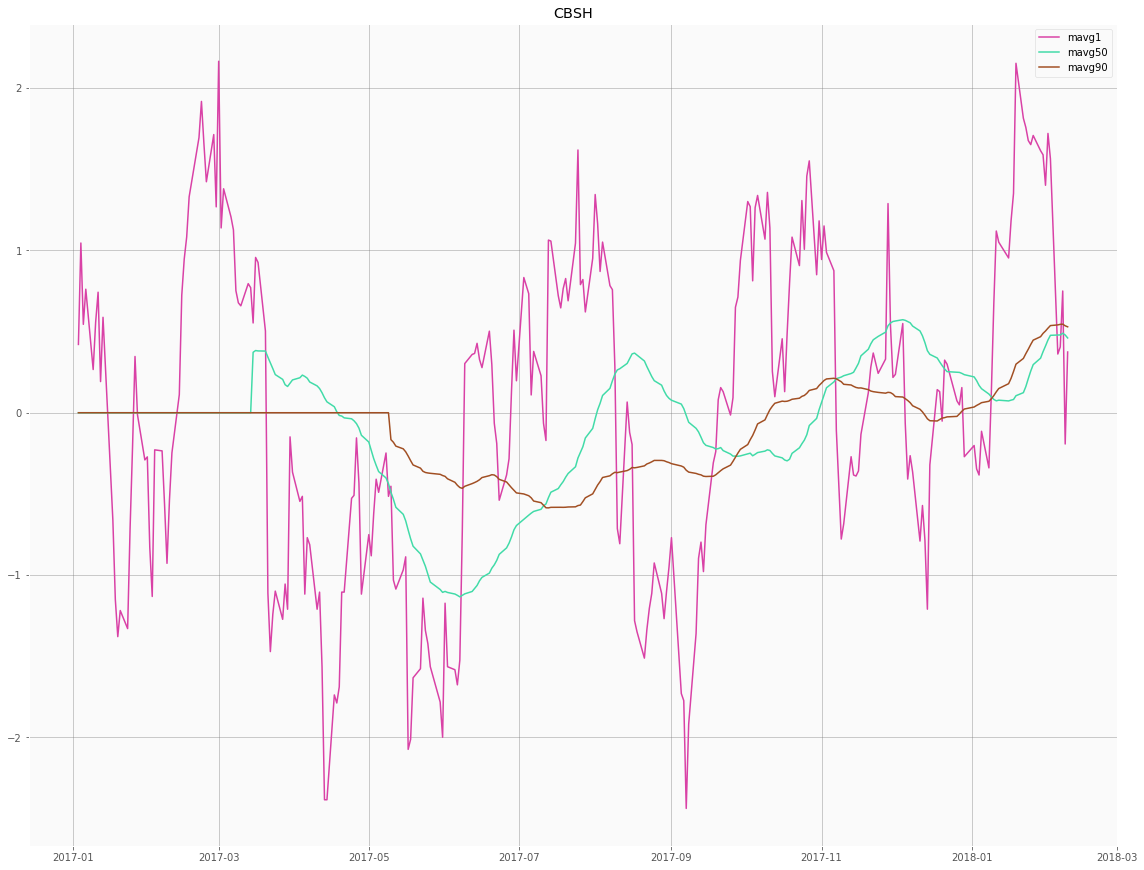

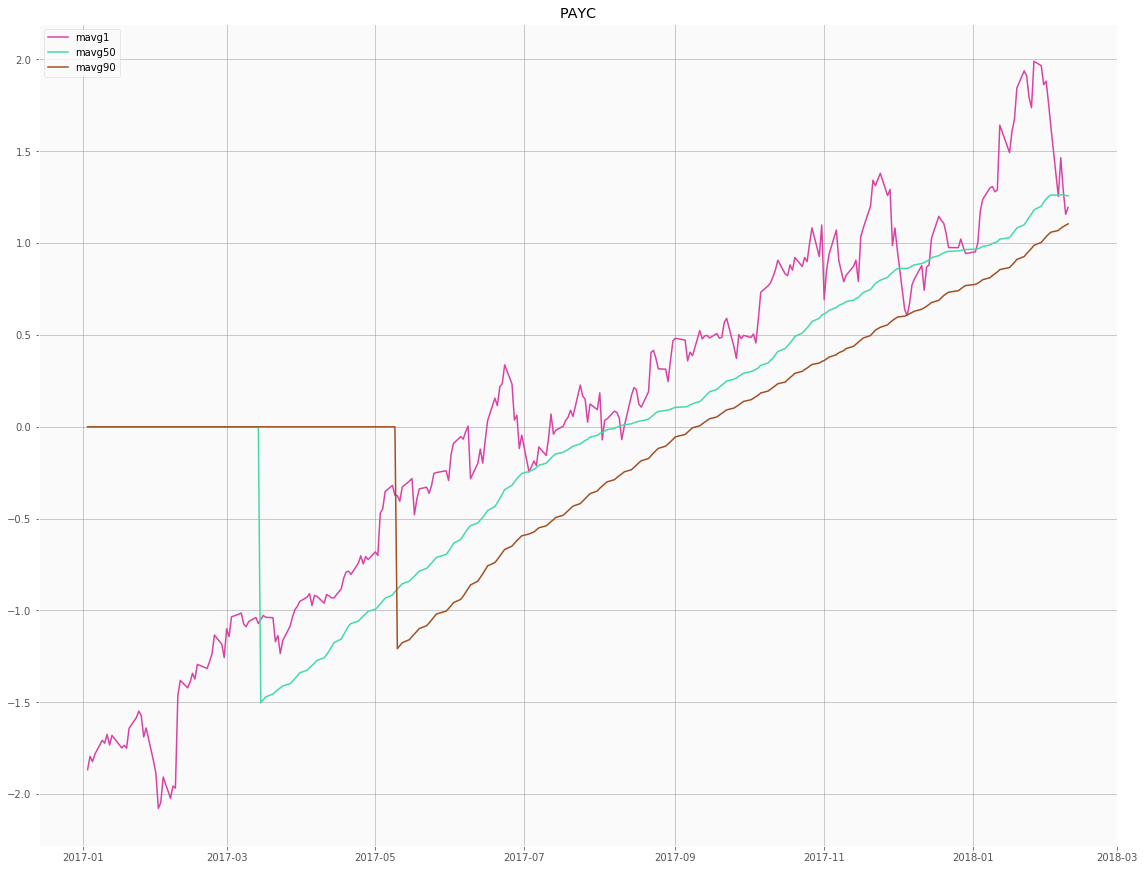

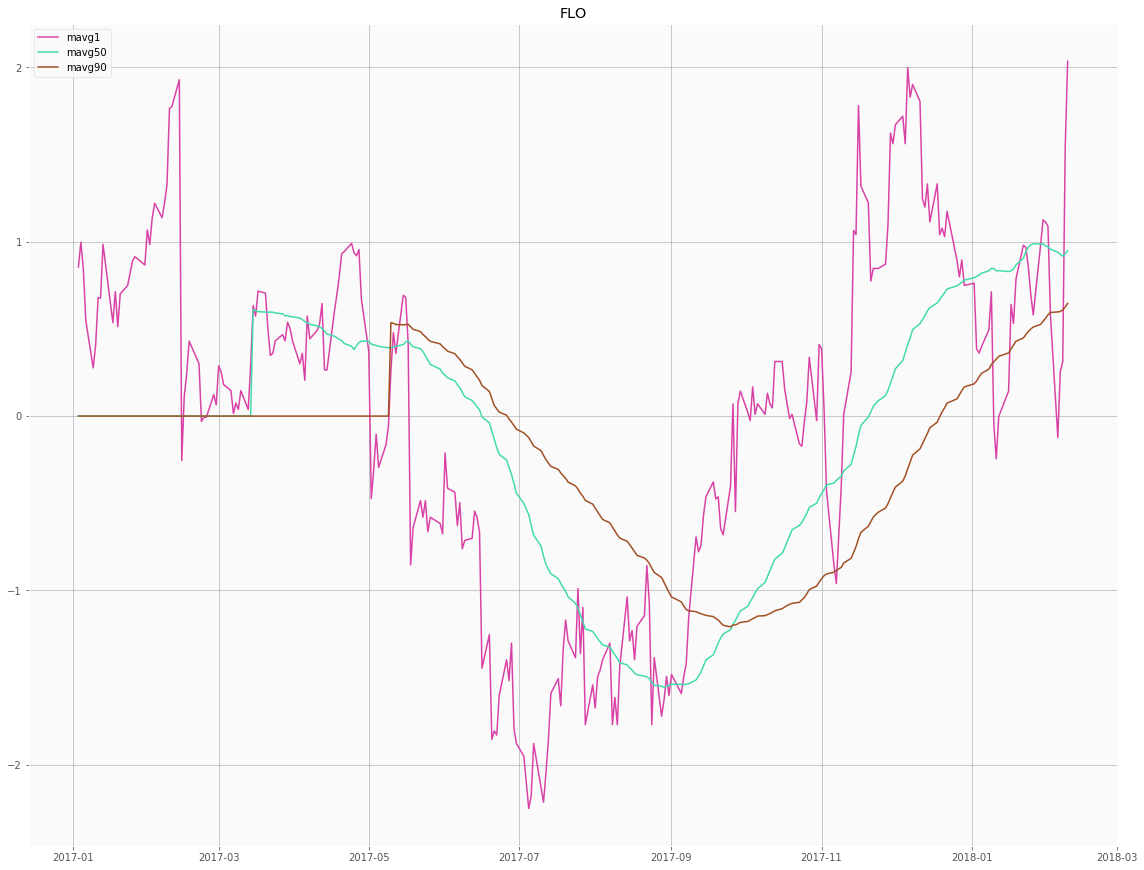

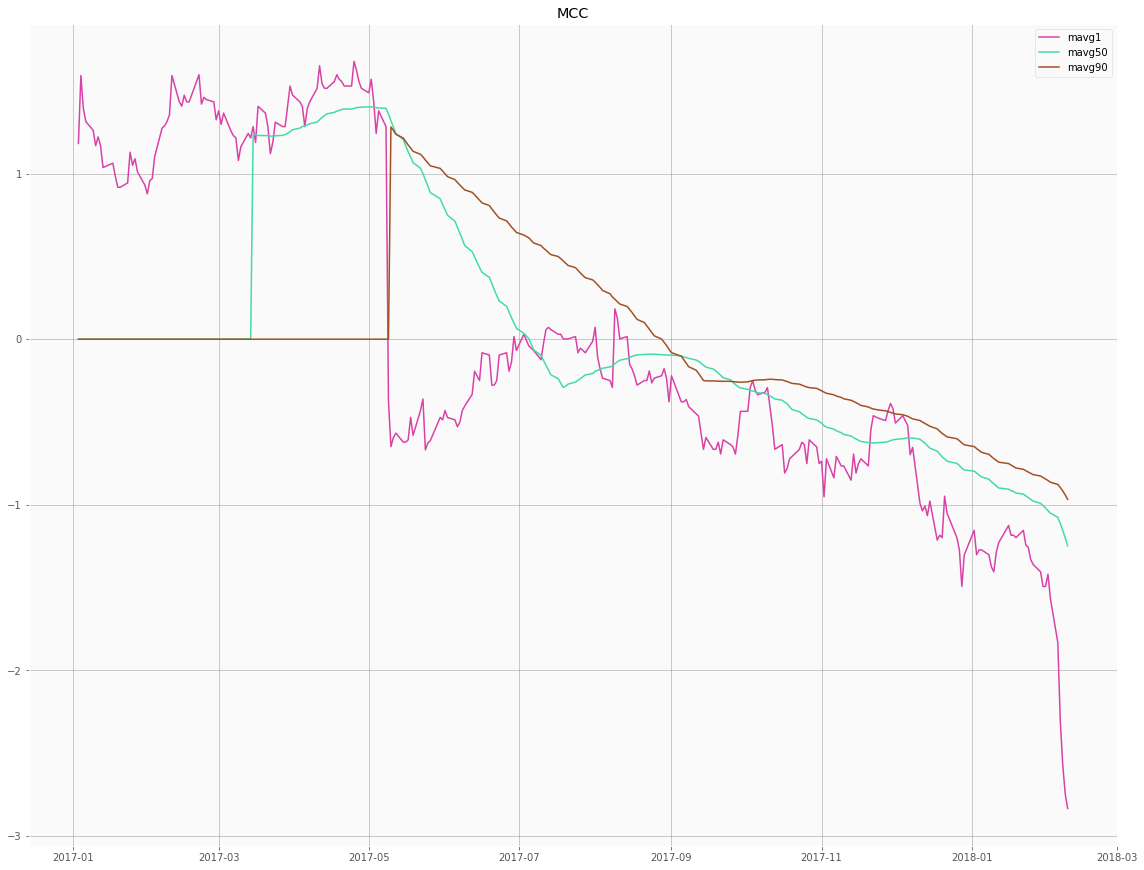

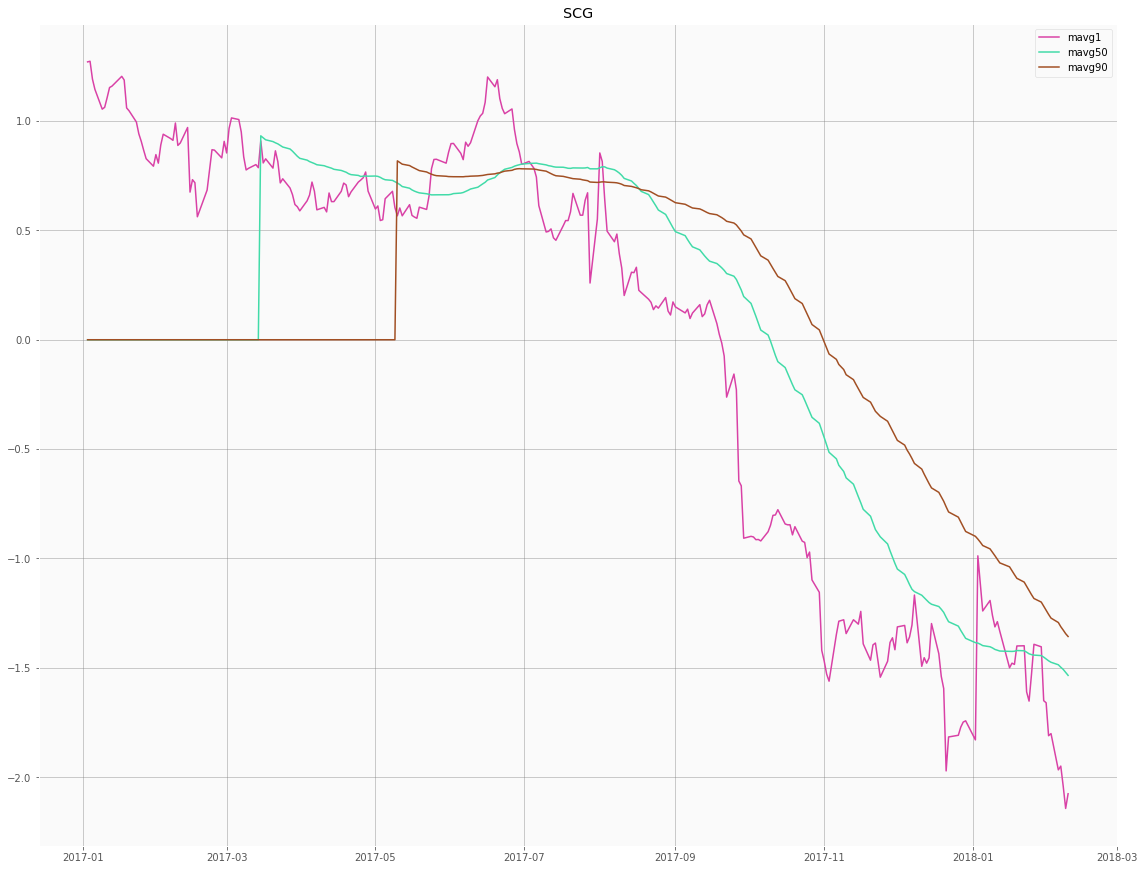

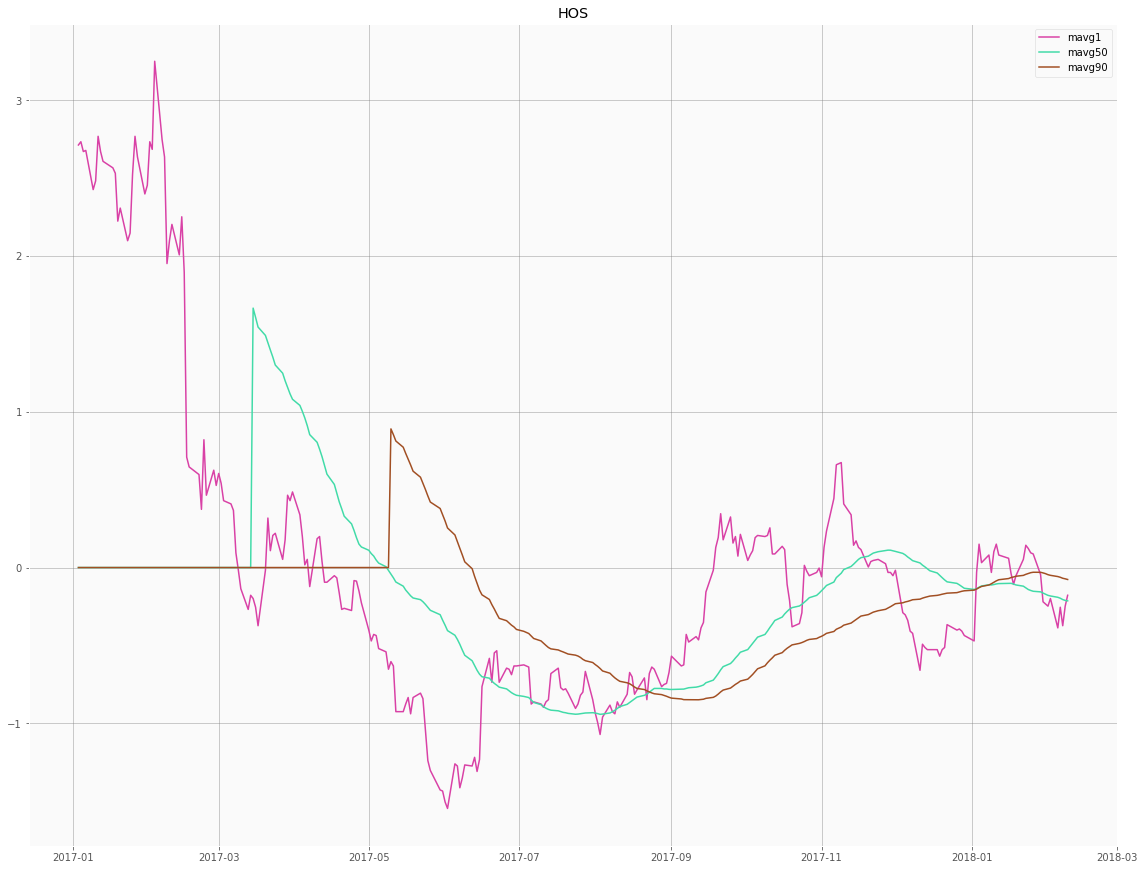

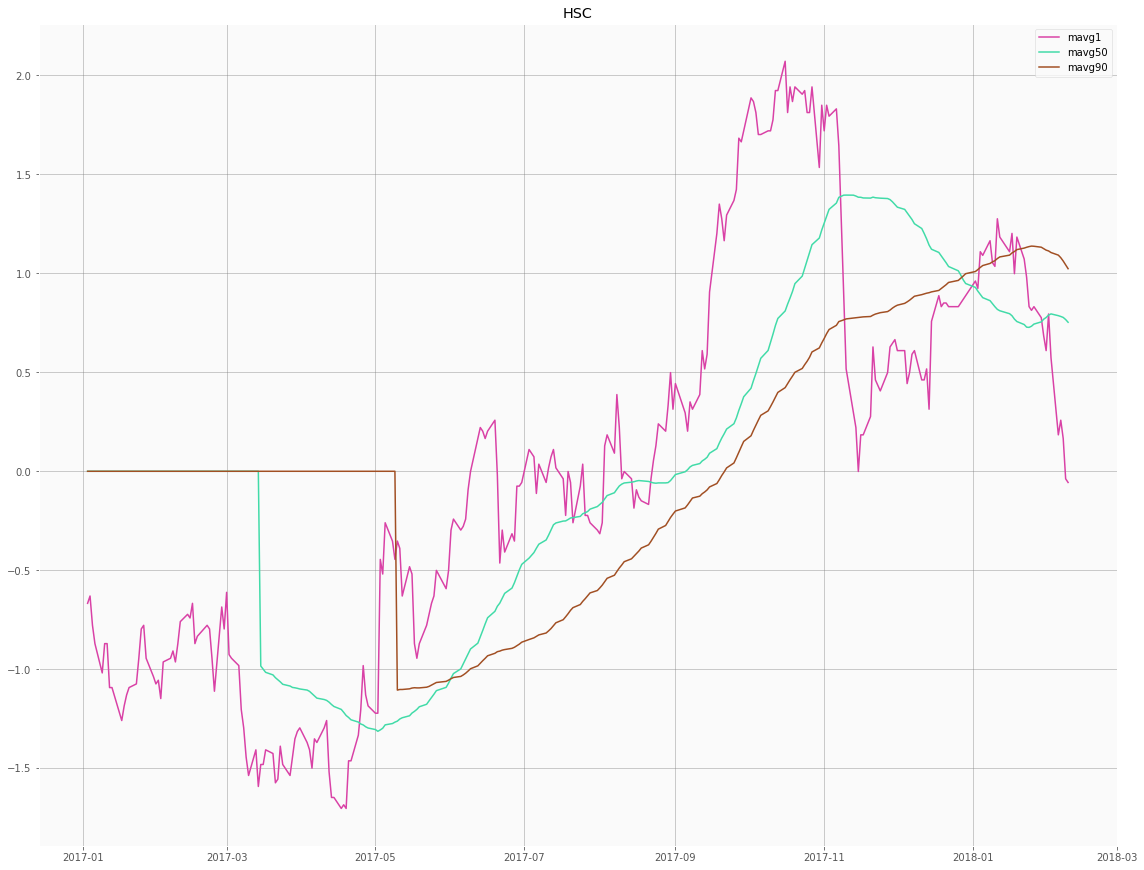

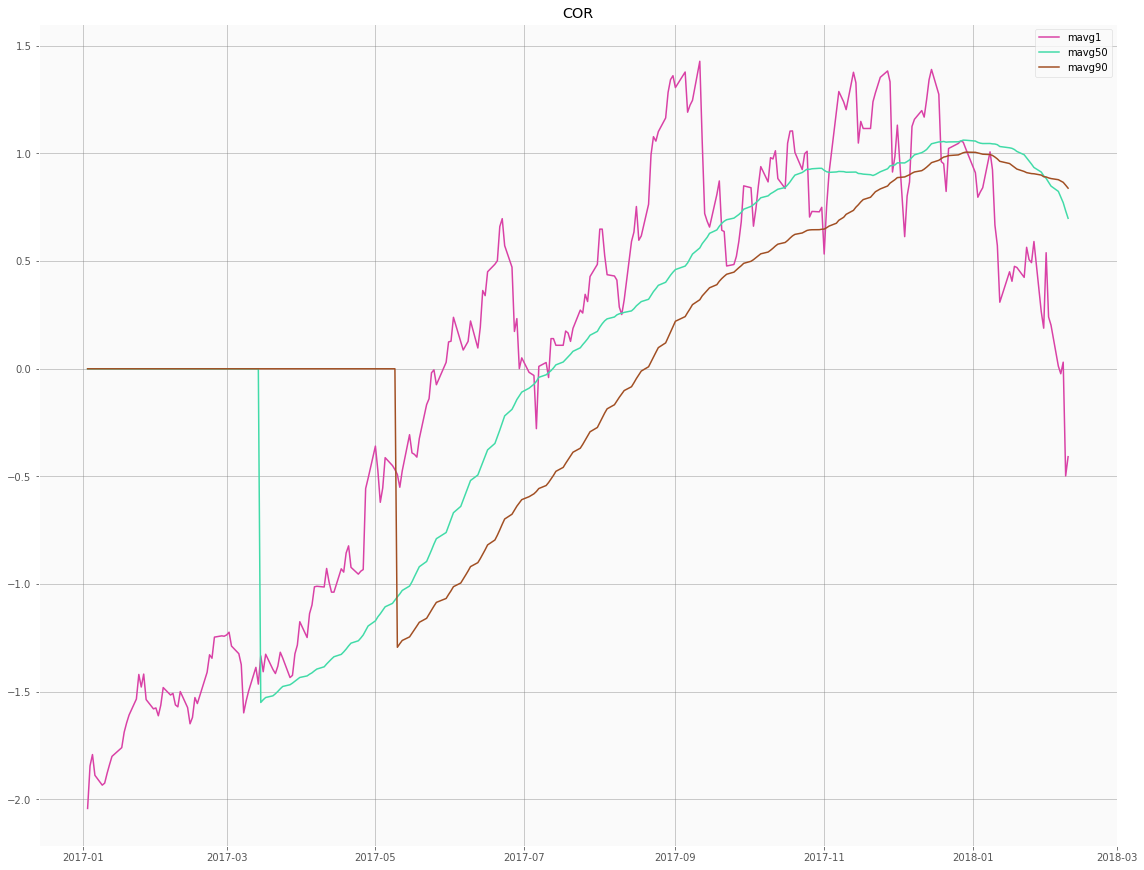

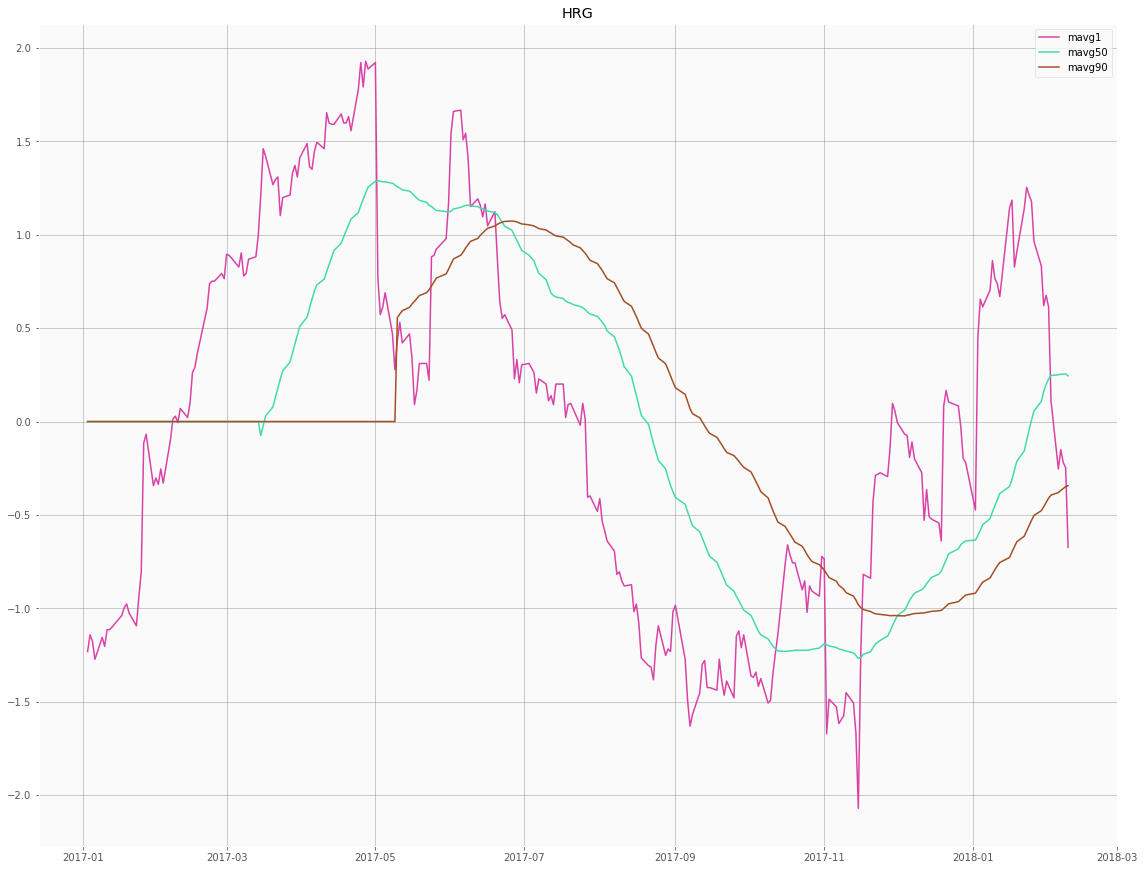

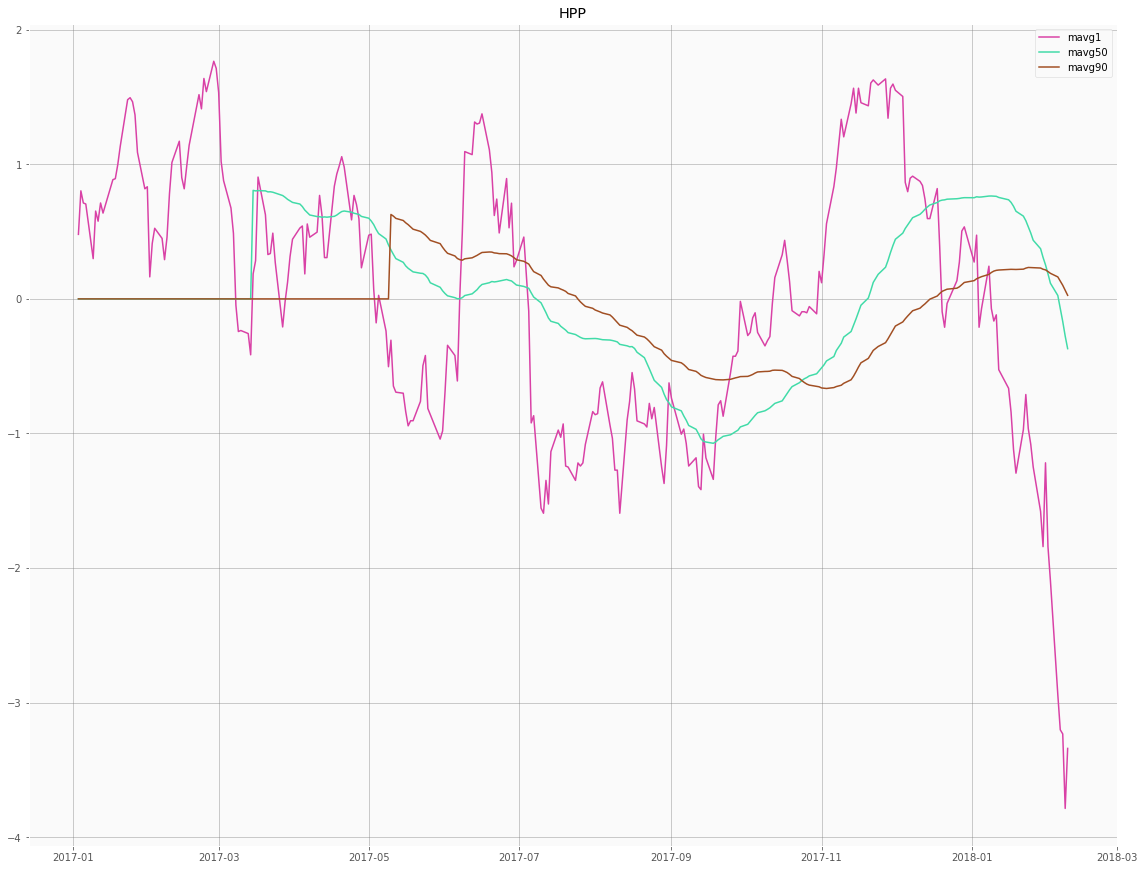

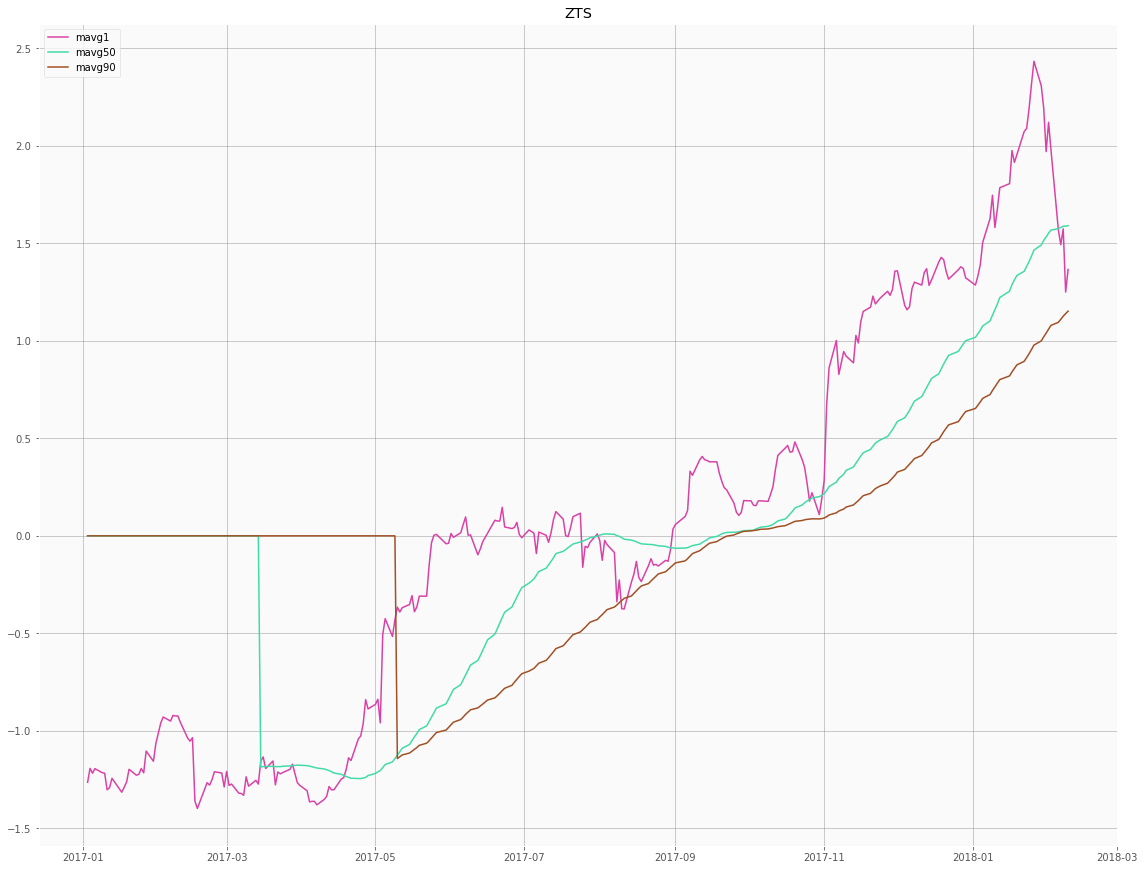

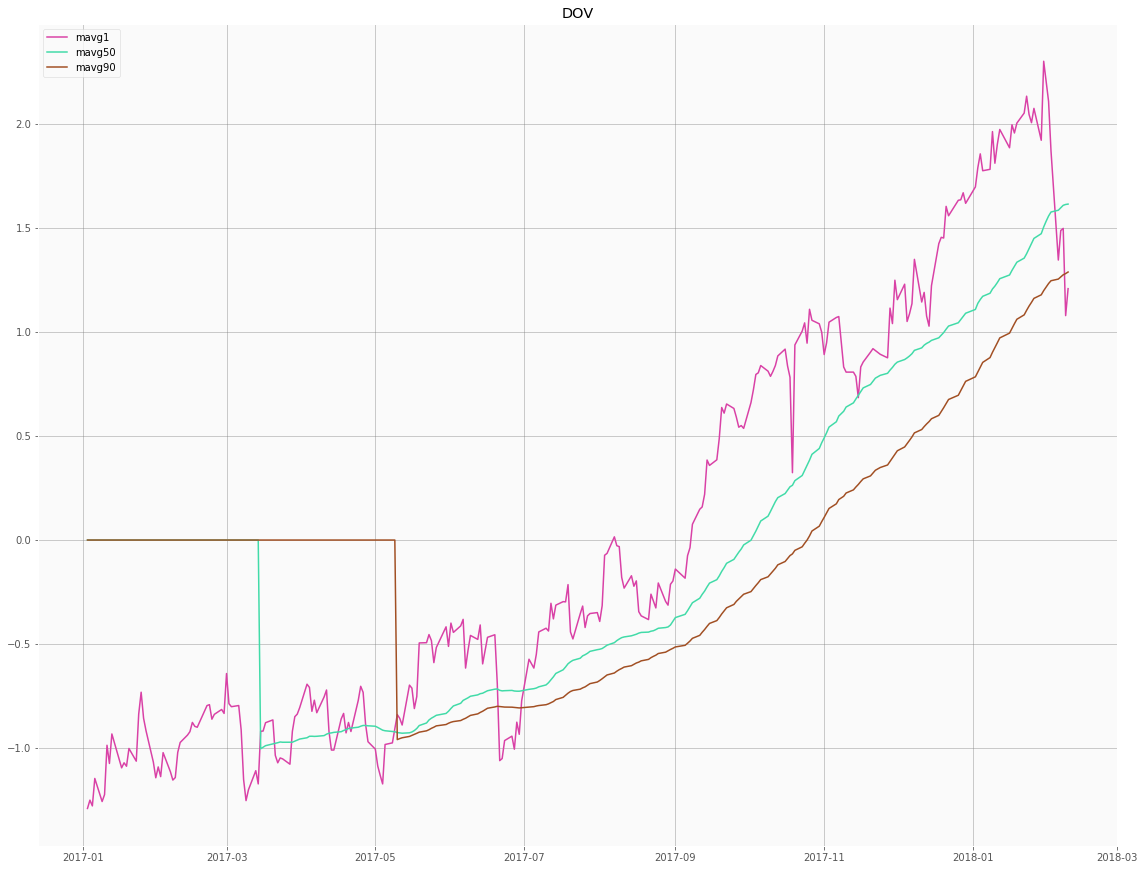

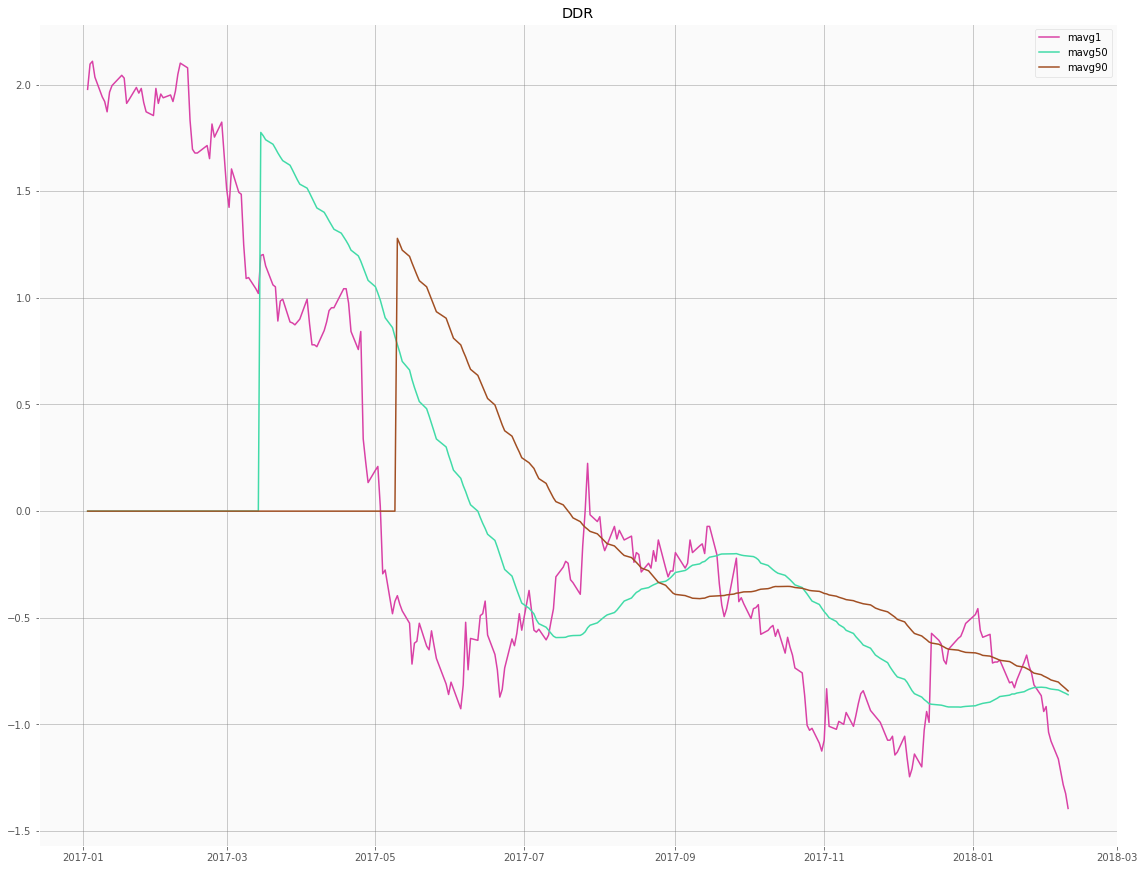

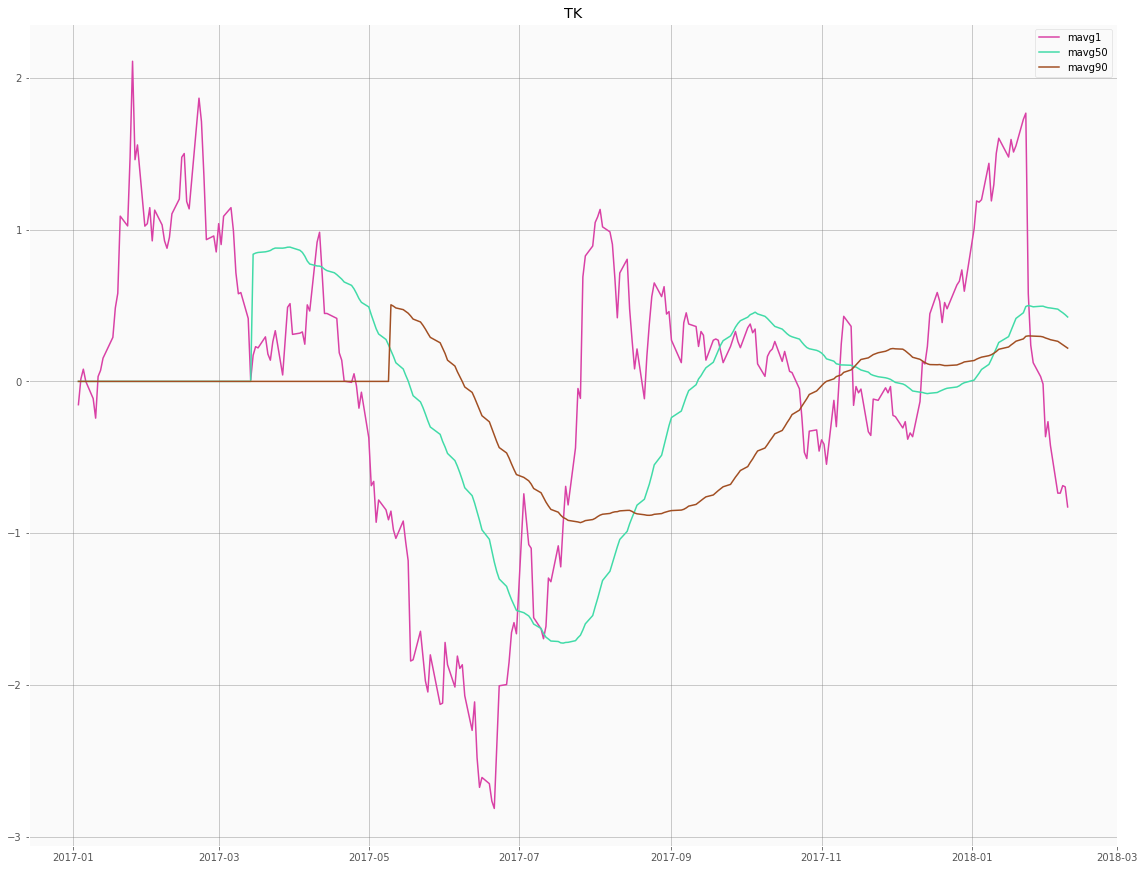

In [31]:
for sym in random.sample(all_sym_df.Symbol.unique().tolist(),50):
    
    sym_df = all_sym_df.loc[all_sym_df.Symbol == sym]
    fig, ax1 = plt.subplots(figsize=(16,12))
    
    buy_dates = sym_df[sym_df.Reversal == 1].Date
    sell_dates = sym_df[sym_df.Reversal == -1].Date
    
    buy_prices = sym_df[sym_df.Date.isin(buy_dates)].Close
    sell_prices = sym_df[sym_df.Date.isin(sell_dates)].Close
    
    
    #ax1.plot(sym_df.Date,sym_df['Close'], color = W.colors[3], label = 'Diff')
    #ax1.legend()
    #ax1.set_ylim(-1,1)
    ax2 = ax1.twinx()
    ax1.plot(sym_df.Date,sym_df['mavg1'],color = W.colors[4], label = 'mavg1')
    ax1.plot(sym_df.Date, sym_df['mavg50'],color = W.colors[5], label = 'mavg50')
    ax1.plot(sym_df.Date, sym_df['mavg90'],color = W.colors[6], label = 'mavg90')
    #ax2.plot(buy_dates, buy_prices, linestyle = 'None', marker = '^', ms = 10, color = W.colors[2])
    #ax2.plot(sell_dates, sell_prices, linestyle = 'None', marker = 'v', ms = 10, color = W.colors[0])
    
    plt.legend()
    fig.tight_layout()
    plt.title('{}'.format(sym))
    plt.show()

In [ ]:

datestart = min(norm_df.Date)


dateend = (str((datetime.datetime.now().date().year))
          + '-' + str((datetime.datetime.now().date().month))
          + '-' + str((datetime.datetime.now().date().day)))

maxs = W.History[['Symbol','Close']].groupby('Symbol').max()
mins = W.History[['Symbol','Close']].groupby('Symbol').min()

norm_df = W.History[['Symbol','Date','Close']]
norm_df['NormPrice'] = norm_df[['Symbol','Close']].groupby('Symbol').transform(lambda x: (x - min(x)) / ( max(x) - min(x)))

symbols = norm_df.Symbol.unique()

mavg_dict = {'Date':norm_df[(norm_df['Date'] >= datestart) 
                                      & (norm_df['Date'] <= dateend)].Date.unique()}

for symbol in symbols:

    for mavg in mavg_set:

        label = symbol + '-' + str(mavg) + 'mavg'

        mavg_dict[label] = norm_df[(norm_df['Symbol'] == symbol) &
                                     (norm_df['Date'] >= datestart) 
                                      & (norm_df['Date'] <= dateend)].NormPrice.rolling(window=mavg).mean().values

norm_mavg_df = pd.DataFrame(mavg_dict)

######### Hard Threshold Runs #####################3

start_time = time.time()

threshold = hard_threshold
headers = ['Date'] + ['mavg' + str(mavg) for mavg in mavg_set] + ['Symbol','Trend','Reversal','Return','Close']
reversals = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64',
                                                        headers[8]:'float64'}, parse_date = 'Date')

all_sym_df = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64',
                                                        headers[8]:'float64'}, parse_date = 'Date')


for symbol in W.symbols:
    cols = ['Date']
    for mavg in mavg_set:
        col = symbol + '-' + str(mavg) + 'mavg'
        cols.append(col)

    sym_df = norm_mavg_df.loc[:,cols]
    sym_df = sym_df.fillna(0)
    sym_df = sym_df.assign(Symbol = symbol)
    sym_df = sym_df.assign(Trend = lambda x: x[cols[2]] < x[cols[3]])
    sym_df = sym_df*1
    sym_df = sym_df.assign(Reversal = 0)
    sym_df = sym_df.assign(Return = 0)

    sym_price = pd.DataFrame(W.History.loc[W.History.Symbol == symbol,['Symbol','Date','Close']])
    sym_df = sym_df.merge(sym_price, on = ['Date','Symbol'])

    sym_df.columns = headers
    sym_df = sym_df.assign(Diff = lambda x: x[headers[2]] - sym_df[headers[3]])


    sym_df.loc[(sym_df['Diff'] < threshold) & (sym_df['Diff'].shift(1) > threshold), 'Reversal'] = -1
    sym_df.loc[(sym_df['Diff'] > threshold) & (sym_df['Diff'].shift(1) < threshold), 'Reversal'] = 1



    rev_df = sym_df[sym_df['Reversal'] != 0]
    rev_df = rev_df.assign(Return = lambda x: x.Close - x.Close.shift(1))
    rev_df.loc[rev_df['Reversal'].shift(1) == -1,'Return'] = -rev_df['Return']
    rev_df = rev_df.assign(PriceNormalizedReturn = lambda x: x.Return/x.Close)

    reversals = pd.concat([reversals,rev_df], ignore_index = True)
    all_sym_df = pd.concat([all_sym_df,sym_df],ignore_index = True)

total_return = reversals.PriceNormalizedReturn.sum()

results.append([mavg_set,threshold,total_return])
elapsed_time = time.time() - start_time
print('{:.3f} seconds | mavg set: {}, hard thresh: {} ------- total return: {:.3f}'.format(elapsed_time,mavg_set, threshold, total_return))
#gc.collect()